<a href="https://colab.research.google.com/github/dgoldblum/RL-Investor/blob/main/ACF_Final_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139    0  4139    0     0  13785      0 --:--:-- --:--:-- --:--:-- 13750
100  517k  100  517k    0     0   500k      0  0:00:01  0:00:01 --:--:--  500k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4115    0  4115    0     0   6876      0 --:--:-- --:--:-- --:--:--  6881
100  392k  100  392k    0     0   324k      0  0:00:01  0:00:01 --:--:-- 1596k


In [ ]:
!pip install stable_baselines3
!pip install 'shimmy>=0.2.1'
# !pip install ray[rllib]
# # !pip install keras-rl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import logging
import tempfile

from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from time import time

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


import gymnasium as gym
from gymnasium.envs.registration import register
from gymnasium import spaces
#from gymnasium.wrappers import FlattenObservation, FlattenDictWrapper
from gymnasium.wrappers import FlattenObservation



import stable_baselines3
#from sb3_plus import MultiOutputPPO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecEnvWrapper, DummyVecEnv, VecNormalize, VecCheckNan
from stable_baselines3.common.env_checker import check_env

# import ray
# from ray import tune
# from ray.rllib.algorithms import ppo
# from ray.tune.registry import register_env


# import keras
# from keras import keras.utils
# import rl
# from rl.agents import PPOAgent
# from rl.memory import SequentialMemory
# from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

import yfinance as yf

#Data

In [ ]:
class DataSource:
    def __init__(self, tickers, trading_days=252, normalize=True):
        self.tickers = tickers
        self.trading_days = trading_days
        self.normalize = normalize
        self.data = self.load_data(tickers)
        #print(np.shape(self.data))
        self.preprocess_data()
        #print(np.shape(self.data))
        self.min_values = self.calculate_min_values()
        self.max_values = self.calculate_max_values()
        self.step = 0
        self.offset = None

    def load_data(self, tickers):
        data_frames = []
        for ticker in tickers:
            raw_data = yf.download(ticker, period='max')
            raw_data.columns = raw_data.columns.str.lower()
            raw_data['ticker'] = ticker  # Add a 'ticker' column
            data_frames.append(raw_data)
            #print(np.shape(raw_data))
        return pd.concat(data_frames)

    def calculate_min_values(self):
        """Calculate the minimum values for each ticker."""
        min_values = {}
        for ticker, df in self.data.items():
            min_values[ticker] = df.min()
        return min_values

    def calculate_max_values(self):
        """Calculate the maximum values for each ticker."""
        max_values = {}
        for ticker, df in self.data.items():
            max_values[ticker] = df.max()
        return max_values

    def preprocess_data(self):
        self.data['returns'] = self.data.close.pct_change()
        self.data['ret_2'] = self.data.close.pct_change(2)
        self.data['ret_5'] = self.data.close.pct_change(5)
        self.data['ret_10'] = self.data.close.pct_change(10)
        self.data['ret_21'] = self.data.close.pct_change(21)
        self.data['rsi'] = talib.STOCHRSI(self.data.close)[1]
        self.data['macd'] = talib.MACD(self.data.close)[1]
        self.data['atr'] = talib.ATR(self.data.high, self.data.low, self.data.close)

        slowk, slowd = talib.STOCH(self.data.high, self.data.low, self.data.close)
        self.data['stoch'] = slowd - slowk
        self.data['atr'] = talib.ATR(self.data.high, self.data.low, self.data.close)
        self.data['ultosc'] = talib.ULTOSC(self.data.high, self.data.low, self.data.close)
        self.data = (self.data.replace((np.inf, -np.inf), np.nan).drop(['high', 'low', 'close', 'volume', 'adj close'], axis=1).dropna())

        r = self.data.returns.copy()
        t = self.data.ticker.copy()
        self.data = self.data.drop('ticker', axis=1)
        if self.normalize:
            self.data = pd.DataFrame(scale(self.data),
                                     columns=self.data.columns,
                                     index=self.data.index)
        features = self.data.columns.drop('returns')
        self.data['returns'] = r  # don't scale returns
        self.data = self.data.loc[:, ['returns'] + list(features)]
        self.data['ticker'] = t


    def reset(self):
        """Provides starting index for time series and resets step"""
        # Calculate the minimum length of time series for each stock ticker
        min_series_lengths = [len(df) for _, df in self.data.groupby('ticker')]
        #print(min_series_lengths)
        # Calculate the high value for the random offset
        high = max(0, min(min_series_lengths) - self.trading_days)
        self.offset = np.random.randint(low=0, high=high)
        self.step = 0

    def take_step(self):
        """Returns data for the current trading day and done signal"""
        observations = {}
        for ticker in self.tickers:
            obs = self.data[self.data['ticker'] == ticker].iloc[self.offset + self.step].drop('ticker').values
            observations[ticker] = np.array(obs, dtype = np.float64)  # Assign observation values to ticker key in the dictionary
        self.step += 1
        done = self.step > self.trading_days
        #print(observations)
        return observations, done

    # def check_nan_values(self):
    #     """Check for NaN values in the preprocessed data."""
    #     nan_counts = self.data.isna().sum()
    #     if nan_counts.sum() > 0:
    #         print("NaN values found in the preprocessed data:")
    #         print(nan_counts)
    #     else:
    #         print("No NaN values found in the preprocessed data.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Enviroment

In [ ]:
class TradingSimulator:
    """ Implements core trading simulator for single-instrument univ """

    def __init__(self, steps, trading_cost_bps, time_cost_bps):
        # invariant for object life
        self.trading_cost_bps = trading_cost_bps
        self.time_cost_bps = time_cost_bps
        self.steps = steps

        # change every step
        self.step = 0
        self.actions = np.zeros(self.steps)
        self.navs = np.ones(self.steps)
        self.market_navs = np.ones(self.steps)
        self.strategy_returns = np.ones(self.steps)
        self.positions = np.zeros(self.steps)
        self.costs = np.zeros(self.steps)
        self.trades = np.zeros(self.steps)
        self.market_returns = np.zeros(self.steps)

    def reset(self):
        self.step = 0
        self.actions.fill(0)
        self.navs.fill(1)
        self.market_navs.fill(1)
        self.strategy_returns.fill(0)
        self.positions.fill(0)
        self.costs.fill(0)
        self.trades.fill(0)
        self.market_returns.fill(0)

    def take_step(self, action, market_return):
        """ Calculates NAVs, trading costs and reward
            based on an action and latest market return
            and returns the reward and a summary of the day's activity. """

        start_position = self.positions[max(0, self.step - 1)]
        start_nav = self.navs[max(0, self.step - 1)]
        start_market_nav = self.market_navs[max(0, self.step - 1)]
        self.market_returns[self.step] = market_return
        self.actions[self.step] = action

        end_position = action - 1  # short, neutral, long
        n_trades = end_position - start_position
        self.positions[self.step] = end_position
        self.trades[self.step] = n_trades

        # roughly value based since starting NAV = 1
        trade_costs = abs(n_trades) * self.trading_cost_bps
        time_cost = 0 if n_trades else self.time_cost_bps
        self.costs[self.step] = trade_costs + time_cost
        reward = start_position * market_return - self.costs[max(0, self.step-1)]
        self.strategy_returns[self.step] = reward

        if self.step != 0:
            self.navs[self.step] = start_nav * (1 + self.strategy_returns[self.step])
            self.market_navs[self.step] = start_market_nav * (1 + self.market_returns[self.step])

        info = {'reward': reward,
                'nav'   : self.navs[self.step],
                'costs' : self.costs[self.step]}

        self.step += 1
        return reward, info

    def result(self):
        """ Returns current state as pd.DataFrame """
        return pd.DataFrame({'action': self.actions,
                             'nav': self.navs,
                             'market_nav': self.market_navs,
                             'market_return': self.market_returns,
                             'strategy_return': self.strategy_returns,
                             'position': self.positions,
                             'cost': self.costs,
                             'trade': self.trades})


class TradingEnvironment(gym.Env):
    def __init__(self, tickers, trading_days=252, trading_cost_bps=1e-3,
                 time_cost_bps=1e-4):
        self.trading_days = trading_days
        self.trading_cost_bps = trading_cost_bps
        self.tickers = tickers
        self.time_cost_bps = time_cost_bps
        self.data_source = DataSource(trading_days=self.trading_days, tickers=self.tickers)
        self.simulators = {ticker: TradingSimulator(steps=self.trading_days,trading_cost_bps=self.trading_cost_bps,
                          time_cost_bps=self.time_cost_bps) for ticker in tickers}
        num_features = len(self.data_source.data.columns) - 1  # Excluding 'returns'
        self.observation_space = spaces.Dict({ticker: spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float64) for ticker in self.tickers})
        self.action_space = spaces.MultiDiscrete([3] * len(self.tickers))  # Multidiscrete action space with 3 actions for each ticker

        self.reset()

    def step(self, actions):
        rewards = 0.0
        dones = {}
        infos = {}
        observations, done = self.data_source.take_step()

        #print("Observations:", observations)
        # print("Done:", done)

        # Assuming actions is a list of actions in the same order as tickers
        for i, ticker in enumerate(self.tickers):
            action = actions[i]
            simulator = self.simulators[ticker]
            reward, info = simulator.take_step(action=action, market_return=observations[ticker][0])

            # print("Ticker:", ticker)
            # print("Action:", action)
            # print("Reward:", reward)
            # print("Info:", info)

            rewards += float(reward)  # Aggregate rewards across all tickers
            dones[ticker] = done
            infos[ticker] = info

        # print("Rewards:", rewards)
        # print("Dones:", dones)

        # # Calculate penalty for deviation from target portfolio weights
        # portfolio_weights = np.array([infos[ticker]['nav'] for ticker in self.tickers])
        # target_weights = np.array([1/len(self.tickers)] * len(self.tickers))  # Assuming equal weights
        # deviation_penalty = -np.sum(np.abs(portfolio_weights - target_weights))

        # print("Portfolio weights:", portfolio_weights)
        # print("Target weights:", target_weights)
        # print("Deviation penalty:", deviation_penalty)

        # # Add penalty to rewards
        # rewards += deviation_penalty

        # Determine if all tickers have terminated
        terminated = all(dones.values())

        # print("Terminated:", terminated)

        # Assume no truncation
        truncated = False

        return observations, rewards, terminated, truncated, infos

    def reset(self, seed=None):
        self.data_source.reset()
        for simulator in self.simulators.values():
            simulator.reset()

        observations, _ = self.data_source.take_step()
        return observations, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

#Agents

In [ ]:
episode_time = []
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

def track_results(ticker, episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    template = '{} | {:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%}'
    print(template.format(str(ticker), episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio))

##PPO

In [ ]:
tickers = ['NVDA', 'TSLA']

In [ ]:
# Define lists to store results
navs = {ticker: [] for ticker in tickers}
market_navs = {ticker: [] for ticker in tickers}
diffs = {ticker: [] for ticker in tickers}

results = {}

# Define the number of episodes and maximum episode steps
max_episodes = 500
max_episode_steps = 252

# Define the environment creation function
def make_env(tickers):
    return TradingEnvironment(tickers)

env = make_env(tickers)
# Create the PPO agent
model = PPO("MultiInputPolicy", env, verbose=1)

# Start time
start = time()
for episode in range(1, max_episodes + 1):
    this_state = env.reset()[0]
    episode_rewards = []

    # Training loop
    for episode_step in range(max_episode_steps):
        action, _ = model.predict(this_state)
        next_state, reward, done, truncated, infos = env.step(action)
        episode_rewards.append(reward)
        if done:
            break
        this_state = next_state

    # Evaluation loop
    for ticker, sim in env.simulators.items():
        results[ticker] = sim.result().iloc[-1]
        #episode_rewards = np.array(episode_rewards)
        #episode_cumulative_reward = np.sum(episode_rewards)
        nav = results[ticker].nav * (1 + results[ticker].strategy_return)
        navs[ticker].append(nav)
        market_nav = results[ticker].market_nav
        market_navs[ticker].append(market_nav)
        diffs[ticker].append(nav - market_nav)

        # Print results every 10 episodes
        if episode % 10 == 0:
            #print(f"Ticker: {ticker}, Episode: {episode}, NAV: {episode_cumulative_reward}, Market NAV: {market_nav}, Difference: {diffs[ticker]}")
            track_results(ticker, episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[ticker][-100:]),
                      np.mean(navs[ticker][-10:]),
                      np.mean(market_navs[ticker][-100:]),
                      np.mean(market_navs[ticker][-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[ticker][-100:]])/min(len(diffs[ticker]), 100),
                      time() - start)
        # # Break condition
        if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
            break

# Close the environment
env.close()

# Save the trained model
ppo = model.save("ppo_trading_model")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   10 | 00:00:16 | Agent:  -2.6% ( -2.6%) | Market:  29.0% ( 29.0%) | Wins: 30.0%
TSLA |   10 | 00:00:16 | Agent: -33.2% (-33.2%) | Market: 122.8% (122.8%) | Wins:  0.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   20 | 00:00:30 | Agent:  -7.4% (-12.3%) | Market:  31.0% ( 33.1%) | Wins: 35.0%
TSLA |   20 | 00:00:30 | Agent: -29.5% (-25.9%) | Market: 114.6% (106.4%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   30 | 00:00:45 | Agent: -17.2% (-36.6%) | Market:  39.2% ( 55.5%) | Wins: 33.3%
TSLA |   30 | 00:00:45 | Agent: -24.6% (-14.7%) | Market: 123.9% (142.7%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   40 | 00:00:60 | Agent: -15.9% (-12.0%) | Market:  59.6% (121.0%) | Wins: 27.5%
TSLA |   40 | 00:00:60 | Agent: -20.1% ( -6.5%) | Market: 100.5% ( 30.1%) | Wins: 12.5%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   50 | 00:01:15 | Agent: -18.8% (-30.3%) | Market:  57.7% ( 50.0%) | Wins: 24.0%
TSLA |   50 | 00:01:15 | Agent: -23.7% (-38.2%) | Market: 102.8% (112.2%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   60 | 00:01:31 | Agent: -18.8% (-18.8%) | Market:  55.1% ( 42.1%) | Wins: 23.3%
TSLA |   60 | 00:01:31 | Agent: -24.4% (-28.1%) | Market: 103.5% (106.7%) | Wins:  8.3%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   70 | 00:01:47 | Agent: -22.2% (-42.8%) | Market:  50.0% ( 19.7%) | Wins: 22.9%
TSLA |   70 | 00:01:47 | Agent: -25.2% (-29.7%) | Market: 109.4% (145.0%) | Wins:  8.6%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   80 | 00:02:02 | Agent: -21.4% (-15.7%) | Market:  53.1% ( 74.7%) | Wins: 22.5%
TSLA |   80 | 00:02:02 | Agent: -25.5% (-27.9%) | Market: 101.6% ( 46.9%) | Wins:  8.8%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   90 | 00:02:17 | Agent: -22.0% (-26.5%) | Market:  47.4% (  2.0%) | Wins: 22.2%
TSLA |   90 | 00:02:17 | Agent: -24.3% (-14.7%) | Market:  92.3% ( 18.2%) | Wins: 11.1%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  100 | 00:02:32 | Agent: -23.2% (-34.0%) | Market:  48.7% ( 60.3%) | Wins: 23.0%
TSLA |  100 | 00:02:32 | Agent: -22.9% (-10.1%) | Market:  88.4% ( 53.1%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  110 | 00:02:47 | Agent: -24.6% (-17.5%) | Market:  51.2% ( 54.0%) | Wins: 25.0%
TSLA |  110 | 00:02:47 | Agent: -22.0% (-24.6%) | Market:  81.4% ( 52.8%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  120 | 00:03:01 | Agent: -26.3% (-28.4%) | Market:  56.7% ( 88.2%) | Wins: 22.0%
TSLA |  120 | 00:03:01 | Agent: -20.8% (-12.9%) | Market:  81.4% (106.3%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  130 | 00:03:16 | Agent: -21.3% ( 12.5%) | Market:  56.9% ( 57.5%) | Wins: 22.0%
TSLA |  130 | 00:03:16 | Agent: -22.7% (-34.5%) | Market:  66.4% ( -7.7%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  140 | 00:03:31 | Agent: -15.4% ( 47.0%) | Market:  53.7% ( 88.5%) | Wins: 23.0%
TSLA |  140 | 00:03:31 | Agent: -24.2% (-21.0%) | Market:  69.4% ( 60.3%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  150 | 00:03:46 | Agent:  -9.7% ( 27.2%) | Market:  60.0% (113.3%) | Wins: 25.0%
TSLA |  150 | 00:03:46 | Agent: -25.0% (-46.8%) | Market:  63.7% ( 55.5%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  160 | 00:04:01 | Agent: -10.1% (-23.2%) | Market:  69.4% (135.8%) | Wins: 24.0%
TSLA |  160 | 00:04:01 | Agent: -25.3% (-30.6%) | Market:  59.7% ( 66.9%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  170 | 00:04:18 | Agent:  -9.3% (-34.7%) | Market:  76.1% ( 86.4%) | Wins: 23.0%
TSLA |  170 | 00:04:18 | Agent: -24.8% (-24.7%) | Market:  50.8% ( 55.5%) | Wins: 19.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  180 | 00:04:34 | Agent: -10.4% (-26.2%) | Market:  73.7% ( 51.3%) | Wins: 24.0%
TSLA |  180 | 00:04:34 | Agent: -21.4% (  6.1%) | Market:  52.2% ( 61.4%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  190 | 00:04:50 | Agent:  -7.4% (  3.2%) | Market:  79.5% ( 59.1%) | Wins: 24.0%
TSLA |  190 | 00:04:50 | Agent: -23.3% (-33.9%) | Market:  57.5% ( 70.7%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  200 | 00:05:05 | Agent:  -4.5% ( -5.1%) | Market:  75.9% ( 25.0%) | Wins: 23.0%
TSLA |  200 | 00:05:05 | Agent: -24.5% (-21.9%) | Market:  55.1% ( 29.6%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  210 | 00:05:20 | Agent:  -6.6% (-38.8%) | Market:  75.2% ( 46.5%) | Wins: 21.0%
TSLA |  210 | 00:05:20 | Agent: -23.5% (-14.4%) | Market:  58.6% ( 87.3%) | Wins: 21.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  220 | 00:05:35 | Agent:  -8.1% (-42.5%) | Market:  71.3% ( 49.7%) | Wins: 21.0%
TSLA |  220 | 00:05:35 | Agent: -24.3% (-21.3%) | Market:  58.1% (102.0%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  230 | 00:05:49 | Agent: -10.5% (-11.9%) | Market:  68.4% ( 27.8%) | Wins: 22.0%
TSLA |  230 | 00:05:49 | Agent: -22.1% (-11.9%) | Market:  61.8% ( 29.2%) | Wins: 19.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  240 | 00:06:04 | Agent: -16.9% (-17.3%) | Market:  66.9% ( 74.1%) | Wins: 21.0%
TSLA |  240 | 00:06:04 | Agent: -22.0% (-20.5%) | Market:  66.0% (101.8%) | Wins: 19.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  250 | 00:06:19 | Agent: -22.0% (-23.9%) | Market:  54.4% (-12.0%) | Wins: 22.0%
TSLA |  250 | 00:06:19 | Agent: -18.7% (-14.0%) | Market:  90.1% (297.0%) | Wins: 21.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  260 | 00:06:35 | Agent: -22.0% (-22.7%) | Market:  41.0% (  1.6%) | Wins: 25.0%
TSLA |  260 | 00:06:35 | Agent: -18.5% (-28.0%) | Market:  87.5% ( 40.3%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  270 | 00:06:50 | Agent: -19.5% ( -9.7%) | Market:  35.8% ( 34.8%) | Wins: 26.0%
TSLA |  270 | 00:06:50 | Agent: -18.4% (-24.0%) | Market:  91.5% ( 96.1%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  280 | 00:07:06 | Agent: -19.7% (-28.7%) | Market:  34.6% ( 39.1%) | Wins: 24.0%
TSLA |  280 | 00:07:06 | Agent: -20.4% (-14.0%) | Market:  92.2% ( 67.9%) | Wins: 16.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  290 | 00:07:21 | Agent: -22.7% (-27.0%) | Market:  44.1% (153.9%) | Wins: 25.0%
TSLA |  290 | 00:07:21 | Agent: -18.1% (-10.7%) | Market:  89.3% ( 41.9%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  300 | 00:07:36 | Agent: -24.8% (-25.5%) | Market:  43.7% ( 21.6%) | Wins: 26.0%
TSLA |  300 | 00:07:36 | Agent: -18.8% (-28.9%) | Market:  89.5% ( 31.0%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  310 | 00:07:50 | Agent: -18.7% ( 22.4%) | Market:  42.1% ( 29.8%) | Wins: 26.0%
TSLA |  310 | 00:07:50 | Agent: -19.1% (-17.6%) | Market:  88.6% ( 79.2%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  320 | 00:08:05 | Agent: -16.5% (-20.8%) | Market:  51.2% (140.7%) | Wins: 27.0%
TSLA |  320 | 00:08:05 | Agent: -19.3% (-23.4%) | Market:  98.4% (199.3%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  330 | 00:08:20 | Agent: -17.9% (-26.2%) | Market:  50.2% ( 18.5%) | Wins: 27.0%
TSLA |  330 | 00:08:20 | Agent: -21.6% (-34.7%) | Market: 106.1% (106.3%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  340 | 00:08:35 | Agent: -19.1% (-28.7%) | Market:  55.5% (126.7%) | Wins: 28.0%
TSLA |  340 | 00:08:35 | Agent: -19.7% ( -1.3%) | Market: 102.9% ( 70.1%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  350 | 00:08:50 | Agent: -19.4% (-27.3%) | Market:  58.4% ( 16.8%) | Wins: 26.0%
TSLA |  350 | 00:08:50 | Agent: -23.0% (-47.5%) | Market:  90.8% (176.0%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  360 | 00:09:05 | Agent: -20.1% (-29.6%) | Market:  59.0% (  8.0%) | Wins: 25.0%
TSLA |  360 | 00:09:05 | Agent: -23.5% (-32.5%) | Market:  94.1% ( 72.7%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  370 | 00:09:20 | Agent: -21.6% (-24.6%) | Market:  59.5% ( 40.2%) | Wins: 25.0%
TSLA |  370 | 00:09:20 | Agent: -25.0% (-39.1%) | Market:  88.4% ( 39.7%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  380 | 00:09:36 | Agent: -21.6% (-28.6%) | Market:  59.7% ( 41.1%) | Wins: 28.0%
TSLA |  380 | 00:09:36 | Agent: -25.3% (-17.3%) | Market: 100.6% (189.7%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  390 | 00:09:50 | Agent: -21.5% (-26.2%) | Market:  47.3% ( 29.9%) | Wins: 27.0%
TSLA |  390 | 00:09:50 | Agent: -27.3% (-31.0%) | Market: 114.1% (177.1%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  400 | 00:10:05 | Agent: -23.5% (-45.7%) | Market:  50.2% ( 50.1%) | Wins: 25.0%
TSLA |  400 | 00:10:05 | Agent: -25.7% (-12.6%) | Market: 114.1% ( 30.5%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  410 | 00:10:20 | Agent: -28.2% (-23.9%) | Market:  48.2% ( 10.1%) | Wins: 26.0%
TSLA |  410 | 00:10:20 | Agent: -25.9% (-19.6%) | Market: 118.4% (122.7%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  420 | 00:10:34 | Agent: -28.5% (-24.1%) | Market:  43.5% ( 93.3%) | Wins: 26.0%
TSLA |  420 | 00:10:34 | Agent: -26.4% (-28.3%) | Market: 110.7% (121.9%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  430 | 00:10:49 | Agent: -28.8% (-28.8%) | Market:  46.9% ( 53.1%) | Wins: 24.0%
TSLA |  430 | 00:10:49 | Agent: -24.6% (-16.4%) | Market: 106.4% ( 63.2%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  440 | 00:11:04 | Agent: -30.0% (-41.5%) | Market:  39.2% ( 49.3%) | Wins: 22.0%
TSLA |  440 | 00:11:04 | Agent: -25.9% (-14.5%) | Market: 105.0% ( 56.4%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  450 | 00:11:19 | Agent: -31.2% (-39.1%) | Market:  42.6% ( 50.8%) | Wins: 21.0%
TSLA |  450 | 00:11:19 | Agent: -22.7% (-15.6%) | Market: 100.5% (131.1%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  460 | 00:11:34 | Agent: -29.3% (-10.7%) | Market:  49.7% ( 78.7%) | Wins: 21.0%
TSLA |  460 | 00:11:34 | Agent: -22.0% (-25.1%) | Market: 111.6% (183.4%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  470 | 00:11:48 | Agent: -30.5% (-36.8%) | Market:  48.7% ( 30.9%) | Wins: 21.0%
TSLA |  470 | 00:11:48 | Agent: -21.0% (-29.3%) | Market: 120.0% (123.7%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  480 | 00:12:03 | Agent: -30.0% (-23.0%) | Market:  52.0% ( 74.0%) | Wins: 20.0%
TSLA |  480 | 00:12:03 | Agent: -22.9% (-36.3%) | Market: 116.4% (153.6%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  490 | 00:12:19 | Agent: -30.4% (-30.0%) | Market:  51.8% ( 27.6%) | Wins: 19.0%
TSLA |  490 | 00:12:19 | Agent: -22.0% (-21.7%) | Market: 108.1% ( 94.6%) | Wins: 13.0%
NVDA |  500 | 00:12:39 | Agent: -28.9% (-30.9%) | Market:  52.2% ( 54.5%) | Wins: 19.0%
TSLA |  500 | 00:12:39 | Agent: -24.4% (-36.7%) | Market: 107.1% ( 20.5%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


##A2C

In [ ]:
# Define lists to store results
navs2 = {ticker: [] for ticker in tickers}
market_navs2 = {ticker: [] for ticker in tickers}
diffs2 = {ticker: [] for ticker in tickers}

results = {}

# Define the number of episodes and maximum episode steps
max_episodes = 1000
max_episode_steps = 252

# Define the environment creation function
def make_env(tickers):
    return TradingEnvironment(tickers)

env = make_env(tickers)
# Create the PPO agent
model2 = A2C("MultiInputPolicy", env, verbose=1)

# Start time
start = time()
for episode in range(1, max_episodes + 1):
    this_state = env.reset()[0]
    episode_rewards = []

    # Training loop
    for episode_step in range(max_episode_steps):
        action, _ = model2.predict(this_state)
        next_state, reward, done, truncated, infos = env.step(action)
        episode_rewards.append(reward)
        if done:
            break
        this_state = next_state

    # Evaluation loop
    for ticker, sim in env.simulators.items():
        results[ticker] = sim.result().iloc[-1]
        #episode_rewards = np.array(episode_rewards)
        #episode_cumulative_reward = np.sum(episode_rewards)
        nav = results[ticker].nav * (1 + results[ticker].strategy_return)
        navs2[ticker].append(nav)
        market_nav = results[ticker].market_nav
        market_navs2[ticker].append(market_nav)
        diffs2[ticker].append(nav - market_nav)

        # Print results every 10 episodes
        if episode % 10 == 0:
            #print(f"Ticker: {ticker}, Episode: {episode}, NAV: {episode_cumulative_reward}, Market NAV: {market_nav}, Difference: {diffs[ticker]}")
            track_results(ticker, episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs2[ticker][-100:]),
                      np.mean(navs2[ticker][-10:]),
                      np.mean(market_navs2[ticker][-100:]),
                      np.mean(market_navs2[ticker][-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs2[ticker][-100:]])/min(len(diffs2[ticker]), 100),
                      time() - start)
        # # Break condition
        if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
            break

# Close the environment
env.close()

# Save the trained model
a2c = model2.save("a2c_trading_model")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   10 | 00:00:42 | Agent: -37.6% (-37.6%) | Market:  22.6% ( 22.6%) | Wins: 10.0%
SMCI |   10 | 00:00:42 | Agent: -25.0% (-25.0%) | Market: 122.3% (122.3%) | Wins:  0.0%
MSTR |   10 | 00:00:42 | Agent: -16.1% (-16.1%) | Market: -22.8% (-22.8%) | Wins: 40.0%
LMT |   10 | 00:00:42 | Agent: -24.2% (-24.2%) | Market:  32.6% ( 32.6%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   20 | 00:01:22 | Agent: -22.0% ( -6.4%) | Market:   8.8% ( -4.9%) | Wins: 30.0%
SMCI |   20 | 00:01:22 | Agent: -29.6% (-34.2%) | Market:  66.8% ( 11.3%) | Wins:  0.0%
MSTR |   20 | 00:01:22 | Agent: -24.7% (-33.3%) | Market: -15.5% ( -8.2%) | Wins: 30.0%
LMT |   20 | 00:01:22 | Agent: -22.2% (-20.3%) | Market:  20.5% (  8.4%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   30 | 00:02:04 | Agent: -15.8% ( -3.5%) | Market:  37.0% ( 93.2%) | Wins: 26.7%
SMCI |   30 | 00:02:04 | Agent: -24.9% (-15.4%) | Market:  64.4% ( 59.8%) | Wins:  6.7%
MSTR |   30 | 00:02:04 | Agent: -29.9% (-40.4%) | Market:  -0.1% ( 30.7%) | Wins: 33.3%
LMT |   30 | 00:02:04 | Agent: -21.5% (-19.9%) | Market:  28.5% ( 44.6%) | Wins: 13.3%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   40 | 00:02:47 | Agent: -15.9% (-16.1%) | Market:  34.6% ( 27.6%) | Wins: 27.5%
SMCI |   40 | 00:02:47 | Agent: -24.1% (-21.6%) | Market:  71.1% ( 91.1%) | Wins: 10.0%
MSTR |   40 | 00:02:47 | Agent: -25.7% (-13.1%) | Market:   1.8% (  7.5%) | Wins: 30.0%
LMT |   40 | 00:02:47 | Agent: -17.0% ( -3.7%) | Market:  22.7% (  5.3%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   50 | 00:03:28 | Agent: -17.0% (-21.5%) | Market:  31.1% ( 17.0%) | Wins: 30.0%
SMCI |   50 | 00:03:28 | Agent: -23.0% (-18.8%) | Market:  86.1% (146.0%) | Wins: 10.0%
MSTR |   50 | 00:03:28 | Agent: -30.1% (-47.5%) | Market:   1.9% (  2.0%) | Wins: 28.0%
LMT |   50 | 00:03:28 | Agent: -18.3% (-23.4%) | Market:  22.9% ( 23.7%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   60 | 00:04:09 | Agent: -14.2% ( -0.2%) | Market:  40.6% ( 88.1%) | Wins: 26.7%
SMCI |   60 | 00:04:09 | Agent: -22.8% (-21.5%) | Market:  79.5% ( 46.6%) | Wins: 11.7%
MSTR |   60 | 00:04:09 | Agent: -29.1% (-24.1%) | Market:  18.1% ( 99.6%) | Wins: 30.0%
LMT |   60 | 00:04:09 | Agent: -18.7% (-20.9%) | Market:  24.8% ( 34.0%) | Wins: 18.3%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   70 | 00:04:51 | Agent: -16.0% (-26.6%) | Market:  43.6% ( 61.7%) | Wins: 24.3%
SMCI |   70 | 00:04:51 | Agent: -23.0% (-24.5%) | Market:  71.9% ( 26.1%) | Wins: 12.9%
MSTR |   70 | 00:04:51 | Agent: -29.6% (-32.3%) | Market:  27.8% ( 85.5%) | Wins: 28.6%
LMT |   70 | 00:04:51 | Agent: -19.2% (-22.3%) | Market:  26.5% ( 36.9%) | Wins: 15.7%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   80 | 00:05:32 | Agent: -16.9% (-23.6%) | Market:  42.7% ( 36.2%) | Wins: 22.5%
SMCI |   80 | 00:05:32 | Agent: -23.9% (-30.0%) | Market:  65.9% ( 24.0%) | Wins: 12.5%
MSTR |   80 | 00:05:32 | Agent: -27.2% (-10.5%) | Market:  31.7% ( 59.3%) | Wins: 32.5%
LMT |   80 | 00:05:32 | Agent: -19.2% (-18.8%) | Market:  29.1% ( 47.1%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |   90 | 00:06:16 | Agent: -16.8% (-15.9%) | Market:  49.1% (100.7%) | Wins: 22.2%
SMCI |   90 | 00:06:16 | Agent: -24.6% (-30.4%) | Market:  63.5% ( 44.6%) | Wins: 11.1%
MSTR |   90 | 00:06:16 | Agent: -27.8% (-32.4%) | Market:  37.4% ( 83.4%) | Wins: 28.9%
LMT |   90 | 00:06:16 | Agent: -19.0% (-17.5%) | Market:  27.4% ( 14.2%) | Wins: 13.3%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  100 | 00:06:58 | Agent: -18.4% (-32.9%) | Market:  47.7% ( 34.6%) | Wins: 21.0%
SMCI |  100 | 00:06:58 | Agent: -23.6% (-14.9%) | Market:  61.3% ( 40.9%) | Wins: 13.0%
MSTR |  100 | 00:06:58 | Agent: -27.8% (-27.7%) | Market:  34.5% (  7.8%) | Wins: 30.0%
LMT |  100 | 00:06:58 | Agent: -20.5% (-34.2%) | Market:  28.2% ( 35.5%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  110 | 00:07:39 | Agent: -17.9% (-32.1%) | Market:  51.5% ( 60.7%) | Wins: 21.0%
SMCI |  110 | 00:07:39 | Agent: -23.5% (-23.8%) | Market:  50.9% ( 18.8%) | Wins: 14.0%
MSTR |  110 | 00:07:39 | Agent: -24.2% ( 19.2%) | Market:  40.1% ( 33.3%) | Wins: 32.0%
LMT |  110 | 00:07:39 | Agent: -19.5% (-14.2%) | Market:  26.4% ( 13.9%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  120 | 00:08:20 | Agent: -18.1% ( -8.7%) | Market:  55.4% ( 34.3%) | Wins: 18.0%
SMCI |  120 | 00:08:20 | Agent: -21.3% (-12.2%) | Market:  50.6% (  7.7%) | Wins: 19.0%
MSTR |  120 | 00:08:20 | Agent: -14.9% ( 59.8%) | Market:  56.1% (151.6%) | Wins: 34.0%
LMT |  120 | 00:08:20 | Agent: -18.6% (-11.5%) | Market:  29.3% ( 37.9%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  130 | 00:09:01 | Agent: -19.4% (-16.0%) | Market:  58.2% (121.5%) | Wins: 18.0%
SMCI |  130 | 00:09:01 | Agent: -22.5% (-27.0%) | Market:  50.8% ( 61.8%) | Wins: 19.0%
MSTR |  130 | 00:09:01 | Agent: -14.6% (-37.5%) | Market:  50.6% (-24.4%) | Wins: 34.0%
LMT |  130 | 00:09:01 | Agent: -18.4% (-17.8%) | Market:  26.5% ( 16.5%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  140 | 00:09:44 | Agent: -20.8% (-30.3%) | Market:  57.3% ( 18.2%) | Wins: 16.0%
SMCI |  140 | 00:09:44 | Agent: -22.6% (-22.6%) | Market:  49.4% ( 77.7%) | Wins: 19.0%
MSTR |  140 | 00:09:44 | Agent: -16.1% (-27.7%) | Market:  52.3% ( 25.3%) | Wins: 34.0%
LMT |  140 | 00:09:44 | Agent: -20.1% (-20.0%) | Market:  26.5% (  5.2%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  150 | 00:10:24 | Agent: -20.0% (-13.2%) | Market:  62.4% ( 68.4%) | Wins: 13.0%
SMCI |  150 | 00:10:24 | Agent: -23.3% (-25.7%) | Market:  35.7% (  9.0%) | Wins: 21.0%
MSTR |  150 | 00:10:24 | Agent: -14.6% (-32.5%) | Market:  53.3% ( 11.4%) | Wins: 37.0%
LMT |  150 | 00:10:24 | Agent: -19.9% (-21.5%) | Market:  26.2% ( 20.5%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  160 | 00:11:05 | Agent: -22.7% (-27.3%) | Market:  57.0% ( 34.0%) | Wins: 14.0%
SMCI |  160 | 00:11:05 | Agent: -22.2% (-10.5%) | Market:  32.2% ( 11.2%) | Wins: 22.0%
MSTR |  160 | 00:11:05 | Agent: -14.7% (-25.4%) | Market:  41.7% (-16.1%) | Wins: 36.0%
LMT |  160 | 00:11:05 | Agent: -20.5% (-27.2%) | Market:  23.2% (  4.1%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  170 | 00:11:46 | Agent: -22.0% (-19.6%) | Market:  53.8% ( 29.5%) | Wins: 13.0%
SMCI |  170 | 00:11:46 | Agent: -23.4% (-36.7%) | Market:  29.7% (  1.3%) | Wins: 21.0%
MSTR |  170 | 00:11:46 | Agent: -13.9% (-24.3%) | Market:  47.5% (143.9%) | Wins: 35.0%
LMT |  170 | 00:11:46 | Agent: -19.5% (-12.8%) | Market:  22.5% ( 29.6%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  180 | 00:12:27 | Agent: -17.7% ( 18.7%) | Market:  51.0% (  7.7%) | Wins: 16.0%
SMCI |  180 | 00:12:27 | Agent: -22.4% (-20.7%) | Market:  29.2% ( 19.4%) | Wins: 23.0%
MSTR |  180 | 00:12:27 | Agent: -13.6% ( -7.4%) | Market:  42.9% ( 13.0%) | Wins: 31.0%
LMT |  180 | 00:12:27 | Agent: -19.7% (-20.6%) | Market:  19.6% ( 18.5%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  190 | 00:13:10 | Agent: -17.5% (-13.1%) | Market:  51.5% (106.0%) | Wins: 17.0%
SMCI |  190 | 00:13:10 | Agent: -22.8% (-33.9%) | Market:  34.4% ( 96.5%) | Wins: 23.0%
MSTR |  190 | 00:13:10 | Agent: -14.8% (-44.2%) | Market:  46.0% (114.2%) | Wins: 32.0%
LMT |  190 | 00:13:10 | Agent: -18.4% ( -4.7%) | Market:  22.3% ( 41.7%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  200 | 00:13:51 | Agent: -16.9% (-27.7%) | Market:  49.0% ( 10.1%) | Wins: 18.0%
SMCI |  200 | 00:13:51 | Agent: -24.4% (-31.4%) | Market:  32.7% ( 23.5%) | Wins: 23.0%
MSTR |  200 | 00:13:51 | Agent: -15.3% (-33.2%) | Market:  42.7% (-24.7%) | Wins: 31.0%
LMT |  200 | 00:13:51 | Agent: -16.7% (-16.9%) | Market:  21.3% ( 25.3%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  210 | 00:14:32 | Agent: -16.7% (-29.4%) | Market:  48.6% ( 56.0%) | Wins: 19.0%
SMCI |  210 | 00:14:32 | Agent: -22.8% ( -7.1%) | Market:  35.4% ( 46.0%) | Wins: 24.0%
MSTR |  210 | 00:14:32 | Agent: -20.1% (-28.5%) | Market:  40.2% (  7.5%) | Wins: 26.0%
LMT |  210 | 00:14:32 | Agent: -18.0% (-27.5%) | Market:  20.3% (  3.7%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  220 | 00:15:13 | Agent: -18.3% (-25.4%) | Market:  56.0% (108.7%) | Wins: 18.0%
SMCI |  220 | 00:15:13 | Agent: -24.5% (-29.3%) | Market:  34.9% (  2.5%) | Wins: 21.0%
MSTR |  220 | 00:15:13 | Agent: -29.4% (-33.5%) | Market:  28.1% ( 31.2%) | Wins: 25.0%
LMT |  220 | 00:15:13 | Agent: -19.8% (-28.9%) | Market:  19.2% ( 26.6%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  230 | 00:15:54 | Agent: -20.1% (-33.6%) | Market:  55.3% (114.3%) | Wins: 18.0%
SMCI |  230 | 00:15:54 | Agent: -22.0% ( -2.7%) | Market:  35.7% ( 69.5%) | Wins: 20.0%
MSTR |  230 | 00:15:54 | Agent: -30.8% (-51.6%) | Market:  35.5% ( 49.3%) | Wins: 22.0%
LMT |  230 | 00:15:54 | Agent: -19.6% (-16.4%) | Market:  20.1% ( 25.5%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  240 | 00:16:37 | Agent: -18.3% (-12.0%) | Market:  55.3% ( 18.0%) | Wins: 19.0%
SMCI |  240 | 00:16:37 | Agent: -22.7% (-29.5%) | Market:  38.6% (107.6%) | Wins: 19.0%
MSTR |  240 | 00:16:37 | Agent: -29.4% (-13.4%) | Market:  41.4% ( 83.8%) | Wins: 23.0%
LMT |  240 | 00:16:37 | Agent: -20.0% (-23.1%) | Market:  21.6% ( 20.6%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  250 | 00:17:18 | Agent: -20.7% (-37.4%) | Market:  50.8% ( 23.4%) | Wins: 20.0%
SMCI |  250 | 00:17:18 | Agent: -22.2% (-20.0%) | Market:  39.7% ( 19.1%) | Wins: 19.0%
MSTR |  250 | 00:17:18 | Agent: -26.5% ( -3.5%) | Market:  36.2% (-40.2%) | Wins: 24.0%
LMT |  250 | 00:17:18 | Agent: -19.5% (-17.2%) | Market:  20.3% (  7.1%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  260 | 00:17:60 | Agent: -21.1% (-31.1%) | Market:  49.2% ( 17.8%) | Wins: 19.0%
SMCI |  260 | 00:17:60 | Agent: -24.7% (-36.1%) | Market:  41.6% ( 31.1%) | Wins: 17.0%
MSTR |  260 | 00:17:60 | Agent: -26.3% (-23.2%) | Market:  40.3% ( 25.1%) | Wins: 24.0%
LMT |  260 | 00:17:60 | Agent: -19.0% (-22.3%) | Market:  22.0% ( 21.7%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  270 | 00:18:40 | Agent: -22.6% (-34.8%) | Market:  52.1% ( 59.1%) | Wins: 20.0%
SMCI |  270 | 00:18:40 | Agent: -24.2% (-31.8%) | Market:  46.3% ( 48.0%) | Wins: 17.0%
MSTR |  270 | 00:18:40 | Agent: -26.8% (-29.8%) | Market:  27.3% ( 14.1%) | Wins: 24.0%
LMT |  270 | 00:18:40 | Agent: -20.0% (-22.8%) | Market:  22.7% ( 36.6%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  280 | 00:19:20 | Agent: -27.2% (-27.4%) | Market:  57.5% ( 61.9%) | Wins: 18.0%
SMCI |  280 | 00:19:20 | Agent: -24.3% (-21.6%) | Market:  46.3% ( 19.5%) | Wins: 16.0%
MSTR |  280 | 00:19:20 | Agent: -29.4% (-33.0%) | Market:  35.5% ( 94.7%) | Wins: 25.0%
LMT |  280 | 00:19:20 | Agent: -20.4% (-23.7%) | Market:  22.7% ( 17.8%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  290 | 00:20:03 | Agent: -29.6% (-36.8%) | Market:  46.0% ( -9.2%) | Wins: 19.0%
SMCI |  290 | 00:20:03 | Agent: -22.5% (-15.1%) | Market:  36.7% (  0.2%) | Wins: 18.0%
MSTR |  290 | 00:20:03 | Agent: -27.7% (-27.3%) | Market:  24.1% (  0.6%) | Wins: 29.0%
LMT |  290 | 00:20:03 | Agent: -21.1% (-12.2%) | Market:  19.7% ( 11.7%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  300 | 00:20:45 | Agent: -30.1% (-33.2%) | Market:  53.0% ( 80.0%) | Wins: 19.0%
SMCI |  300 | 00:20:45 | Agent: -22.2% (-29.2%) | Market:  37.1% ( 27.2%) | Wins: 17.0%
MSTR |  300 | 00:20:45 | Agent: -26.1% (-17.2%) | Market:  32.0% ( 53.7%) | Wins: 28.0%
LMT |  300 | 00:20:45 | Agent: -21.7% (-22.9%) | Market:  19.1% ( 19.4%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  310 | 00:21:26 | Agent: -30.8% (-36.3%) | Market:  51.2% ( 37.6%) | Wins: 18.0%
SMCI |  310 | 00:21:26 | Agent: -24.0% (-24.3%) | Market:  41.6% ( 91.0%) | Wins: 15.0%
MSTR |  310 | 00:21:26 | Agent: -24.1% ( -8.4%) | Market:  32.9% ( 16.5%) | Wins: 30.0%
LMT |  310 | 00:21:26 | Agent: -20.6% (-16.7%) | Market:  20.9% ( 22.2%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  320 | 00:22:07 | Agent: -30.9% (-26.0%) | Market:  49.9% ( 96.3%) | Wins: 19.0%
SMCI |  320 | 00:22:07 | Agent: -21.2% ( -1.5%) | Market:  46.6% ( 52.6%) | Wins: 14.0%
MSTR |  320 | 00:22:07 | Agent: -21.6% ( -8.8%) | Market:  33.6% ( 38.2%) | Wins: 31.0%
LMT |  320 | 00:22:07 | Agent: -19.7% (-19.8%) | Market:  20.7% ( 24.5%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  330 | 00:22:50 | Agent: -30.9% (-34.2%) | Market:  42.3% ( 38.4%) | Wins: 18.0%
SMCI |  330 | 00:22:50 | Agent: -22.1% (-12.4%) | Market:  44.0% ( 43.7%) | Wins: 15.0%
MSTR |  330 | 00:22:50 | Agent: -16.2% (  2.9%) | Market:  43.5% (148.7%) | Wins: 33.0%
LMT |  330 | 00:22:50 | Agent: -19.2% (-11.4%) | Market:  19.6% ( 14.2%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  340 | 00:23:32 | Agent: -32.6% (-28.2%) | Market:  46.3% ( 58.1%) | Wins: 16.0%
SMCI |  340 | 00:23:32 | Agent: -20.0% ( -7.9%) | Market:  39.7% ( 65.0%) | Wins: 16.0%
MSTR |  340 | 00:23:32 | Agent: -19.4% (-45.6%) | Market:  46.3% (111.5%) | Wins: 30.0%
LMT |  340 | 00:23:32 | Agent: -19.1% (-22.2%) | Market:  22.0% ( 44.6%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  350 | 00:24:13 | Agent: -29.5% ( -6.9%) | Market:  43.4% ( -5.5%) | Wins: 18.0%
SMCI |  350 | 00:24:13 | Agent: -19.5% (-15.2%) | Market:  38.0% (  1.2%) | Wins: 16.0%
MSTR |  350 | 00:24:13 | Agent: -21.6% (-25.4%) | Market:  49.8% ( -4.9%) | Wins: 26.0%
LMT |  350 | 00:24:13 | Agent: -20.0% (-25.9%) | Market:  23.0% ( 17.5%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  360 | 00:24:54 | Agent: -28.7% (-22.9%) | Market:  45.3% ( 35.9%) | Wins: 17.0%
SMCI |  360 | 00:24:54 | Agent: -18.0% (-20.6%) | Market:  40.2% ( 53.2%) | Wins: 17.0%
MSTR |  360 | 00:24:54 | Agent: -22.1% (-28.1%) | Market:  48.4% ( 10.6%) | Wins: 26.0%
LMT |  360 | 00:24:54 | Agent: -21.0% (-32.3%) | Market:  22.7% ( 18.2%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  370 | 00:25:35 | Agent: -25.9% ( -6.7%) | Market:  41.4% ( 20.8%) | Wins: 19.0%
SMCI |  370 | 00:25:35 | Agent: -16.0% (-11.8%) | Market:  43.1% ( 77.5%) | Wins: 17.0%
MSTR |  370 | 00:25:35 | Agent: -20.7% (-16.6%) | Market:  52.3% ( 53.7%) | Wins: 28.0%
LMT |  370 | 00:25:35 | Agent: -20.2% (-14.9%) | Market:  21.6% ( 26.2%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  380 | 00:26:18 | Agent: -24.5% (-13.6%) | Market:  37.3% ( 20.9%) | Wins: 20.0%
SMCI |  380 | 00:26:18 | Agent: -16.9% (-31.3%) | Market:  45.3% ( 40.9%) | Wins: 15.0%
MSTR |  380 | 00:26:18 | Agent: -21.7% (-42.8%) | Market:  42.5% ( -3.5%) | Wins: 29.0%
LMT |  380 | 00:26:18 | Agent: -18.6% ( -8.0%) | Market:  21.9% ( 20.4%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  390 | 00:26:58 | Agent: -23.0% (-22.0%) | Market:  44.4% ( 61.2%) | Wins: 17.0%
SMCI |  390 | 00:26:58 | Agent: -18.2% (-27.8%) | Market:  47.2% ( 19.2%) | Wins: 14.0%
MSTR |  390 | 00:26:58 | Agent: -20.9% (-18.8%) | Market:  70.9% (284.2%) | Wins: 27.0%
LMT |  390 | 00:26:58 | Agent: -19.2% (-18.1%) | Market:  23.9% ( 32.1%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  400 | 00:27:38 | Agent: -21.5% (-17.6%) | Market:  46.2% ( 98.3%) | Wins: 17.0%
SMCI |  400 | 00:27:38 | Agent: -18.3% (-29.8%) | Market:  45.4% (  9.4%) | Wins: 16.0%
MSTR |  400 | 00:27:38 | Agent: -21.8% (-26.4%) | Market:  76.1% (105.6%) | Wins: 28.0%
LMT |  400 | 00:27:38 | Agent: -18.7% (-17.9%) | Market:  24.4% ( 24.1%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  410 | 00:28:19 | Agent: -20.3% (-24.3%) | Market:  41.4% (-10.8%) | Wins: 21.0%
SMCI |  410 | 00:28:19 | Agent: -18.7% (-28.8%) | Market:  37.6% ( 12.8%) | Wins: 19.0%
MSTR |  410 | 00:28:19 | Agent: -21.9% ( -9.1%) | Market:  75.8% ( 14.3%) | Wins: 29.0%
LMT |  410 | 00:28:19 | Agent: -17.4% ( -4.1%) | Market:  22.9% (  7.1%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  420 | 00:29:00 | Agent: -22.0% (-43.2%) | Market:  45.6% (138.7%) | Wins: 21.0%
SMCI |  420 | 00:29:00 | Agent: -21.0% (-24.1%) | Market:  34.2% ( 18.5%) | Wins: 22.0%
MSTR |  420 | 00:29:00 | Agent: -23.3% (-23.1%) | Market:  77.2% ( 52.2%) | Wins: 27.0%
LMT |  420 | 00:29:00 | Agent: -16.6% (-11.7%) | Market:  24.4% ( 39.5%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  430 | 00:29:43 | Agent: -22.3% (-37.4%) | Market:  46.0% ( 42.4%) | Wins: 22.0%
SMCI |  430 | 00:29:43 | Agent: -21.8% (-20.4%) | Market:  29.9% (  1.4%) | Wins: 24.0%
MSTR |  430 | 00:29:43 | Agent: -22.2% ( 13.6%) | Market:  61.5% ( -8.4%) | Wins: 29.0%
LMT |  430 | 00:29:43 | Agent: -17.2% (-17.2%) | Market:  23.9% (  9.7%) | Wins: 16.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  440 | 00:30:24 | Agent: -20.4% ( -9.7%) | Market:  41.7% ( 15.1%) | Wins: 25.0%
SMCI |  440 | 00:30:24 | Agent: -23.4% (-24.5%) | Market:  25.5% ( 20.8%) | Wins: 25.0%
MSTR |  440 | 00:30:24 | Agent: -20.5% (-28.0%) | Market:  52.2% ( 18.1%) | Wins: 33.0%
LMT |  440 | 00:30:24 | Agent: -15.4% ( -3.8%) | Market:  21.9% ( 24.4%) | Wins: 19.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  450 | 00:31:06 | Agent: -20.9% (-11.7%) | Market:  48.4% ( 61.1%) | Wins: 24.0%
SMCI |  450 | 00:31:06 | Agent: -24.0% (-21.3%) | Market:  28.3% ( 29.5%) | Wins: 23.0%
MSTR |  450 | 00:31:06 | Agent: -17.6% (  3.6%) | Market:  65.5% (128.0%) | Wins: 33.0%
LMT |  450 | 00:31:06 | Agent: -15.4% (-25.7%) | Market:  21.3% ( 11.7%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  460 | 00:31:46 | Agent: -21.3% (-26.5%) | Market:  53.6% ( 88.7%) | Wins: 26.0%
SMCI |  460 | 00:31:46 | Agent: -22.4% ( -4.0%) | Market:  25.8% ( 27.6%) | Wins: 24.0%
MSTR |  460 | 00:31:46 | Agent: -14.5% (  2.9%) | Market:  78.3% (139.1%) | Wins: 33.0%
LMT |  460 | 00:31:46 | Agent: -13.8% (-16.8%) | Market:  21.0% ( 15.0%) | Wins: 20.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  470 | 00:32:28 | Agent: -21.9% (-12.9%) | Market:  60.0% ( 84.7%) | Wins: 25.0%
SMCI |  470 | 00:32:28 | Agent: -23.5% (-22.5%) | Market:  19.9% ( 19.4%) | Wins: 25.0%
MSTR |  470 | 00:32:28 | Agent: -17.5% (-47.3%) | Market:  77.2% ( 42.1%) | Wins: 33.0%
LMT |  470 | 00:32:28 | Agent: -13.5% (-11.7%) | Market:  21.4% ( 30.5%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  480 | 00:33:12 | Agent: -23.6% (-30.2%) | Market:  60.7% ( 27.4%) | Wins: 24.0%
SMCI |  480 | 00:33:12 | Agent: -22.8% (-25.1%) | Market:  22.2% ( 63.1%) | Wins: 28.0%
MSTR |  480 | 00:33:12 | Agent: -15.2% (-19.2%) | Market:  83.8% ( 63.1%) | Wins: 32.0%
LMT |  480 | 00:33:12 | Agent: -13.6% ( -9.4%) | Market:  23.0% ( 35.9%) | Wins: 18.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  490 | 00:33:56 | Agent: -24.9% (-35.0%) | Market:  62.7% ( 81.7%) | Wins: 25.0%
SMCI |  490 | 00:33:56 | Agent: -22.3% (-22.4%) | Market:  22.5% ( 22.7%) | Wins: 29.0%
MSTR |  490 | 00:33:56 | Agent: -14.9% (-16.5%) | Market:  64.1% ( 86.9%) | Wins: 32.0%
LMT |  490 | 00:33:56 | Agent: -13.6% (-17.6%) | Market:  22.6% ( 27.8%) | Wins: 19.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  500 | 00:34:41 | Agent: -26.7% (-36.1%) | Market:  64.7% (118.2%) | Wins: 23.0%
SMCI |  500 | 00:34:41 | Agent: -23.0% (-36.8%) | Market:  25.8% ( 42.2%) | Wins: 28.0%
MSTR |  500 | 00:34:41 | Agent:  -9.9% ( 24.4%) | Market:  75.8% (223.0%) | Wins: 32.0%
LMT |  500 | 00:34:41 | Agent: -14.8% (-29.4%) | Market:  22.7% ( 25.9%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  510 | 00:35:26 | Agent: -26.6% (-23.3%) | Market:  71.3% ( 55.2%) | Wins: 20.0%
SMCI |  510 | 00:35:26 | Agent: -22.4% (-22.7%) | Market:  24.9% (  3.7%) | Wins: 27.0%
MSTR |  510 | 00:35:26 | Agent: -11.1% (-21.8%) | Market:  79.2% ( 48.3%) | Wins: 30.0%
LMT |  510 | 00:35:26 | Agent: -17.1% (-27.6%) | Market:  22.8% (  7.5%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  520 | 00:36:13 | Agent: -26.2% (-39.7%) | Market:  58.7% ( 12.2%) | Wins: 20.0%
SMCI |  520 | 00:36:13 | Agent: -22.5% (-25.7%) | Market:  29.6% ( 65.7%) | Wins: 25.0%
MSTR |  520 | 00:36:13 | Agent: -11.4% (-26.0%) | Market:  85.8% (117.7%) | Wins: 31.0%
LMT |  520 | 00:36:13 | Agent: -18.8% (-29.0%) | Market:  22.6% ( 38.0%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  530 | 00:36:56 | Agent: -21.9% (  5.9%) | Market:  57.9% ( 34.3%) | Wins: 20.0%
SMCI |  530 | 00:36:56 | Agent: -23.6% (-31.4%) | Market:  37.8% ( 83.0%) | Wins: 22.0%
MSTR |  530 | 00:36:56 | Agent: -13.4% ( -5.7%) | Market:  95.9% ( 93.1%) | Wins: 30.0%
LMT |  530 | 00:36:56 | Agent: -19.9% (-27.9%) | Market:  23.3% ( 16.5%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  540 | 00:37:40 | Agent: -23.5% (-26.0%) | Market:  57.0% (  6.1%) | Wins: 19.0%
SMCI |  540 | 00:37:40 | Agent: -24.7% (-35.6%) | Market:  38.9% ( 32.5%) | Wins: 19.0%
MSTR |  540 | 00:37:40 | Agent: -11.3% ( -7.7%) | Market:  97.8% ( 36.6%) | Wins: 28.0%
LMT |  540 | 00:37:40 | Agent: -21.3% (-17.5%) | Market:  22.4% ( 14.9%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  550 | 00:38:24 | Agent: -25.2% (-28.6%) | Market:  55.1% ( 42.6%) | Wins: 18.0%
SMCI |  550 | 00:38:24 | Agent: -25.8% (-32.0%) | Market:  38.1% ( 20.8%) | Wins: 19.0%
MSTR |  550 | 00:38:24 | Agent: -14.5% (-27.8%) | Market:  95.8% (108.4%) | Wins: 28.0%
LMT |  550 | 00:38:24 | Agent: -20.0% (-12.9%) | Market:  24.0% ( 28.1%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  560 | 00:39:09 | Agent: -25.5% (-29.4%) | Market:  58.1% (118.0%) | Wins: 17.0%
SMCI |  560 | 00:39:09 | Agent: -28.8% (-33.7%) | Market:  38.5% ( 31.8%) | Wins: 18.0%
MSTR |  560 | 00:39:09 | Agent: -15.2% ( -4.7%) | Market:  93.7% (117.8%) | Wins: 29.0%
LMT |  560 | 00:39:09 | Agent: -21.2% (-29.3%) | Market:  24.7% ( 22.5%) | Wins:  9.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  570 | 00:39:52 | Agent: -27.5% (-33.2%) | Market:  59.8% (101.7%) | Wins: 17.0%
SMCI |  570 | 00:39:52 | Agent: -25.8% (  7.0%) | Market:  38.6% ( 20.8%) | Wins: 20.0%
MSTR |  570 | 00:39:52 | Agent: -12.6% (-21.1%) | Market:  91.6% ( 21.5%) | Wins: 31.0%
LMT |  570 | 00:39:52 | Agent: -19.7% (  4.0%) | Market:  25.7% ( 40.4%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  580 | 00:40:36 | Agent: -26.6% (-20.8%) | Market:  58.9% ( 18.4%) | Wins: 17.0%
SMCI |  580 | 00:40:36 | Agent: -27.1% (-38.3%) | Market:  33.6% ( 12.8%) | Wins: 18.0%
MSTR |  580 | 00:40:36 | Agent: -13.4% (-26.7%) | Market:  87.2% ( 18.5%) | Wins: 32.0%
LMT |  580 | 00:40:36 | Agent: -20.6% (-19.0%) | Market:  23.0% (  8.8%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  590 | 00:41:18 | Agent: -27.1% (-39.5%) | Market:  54.6% ( 39.6%) | Wins: 15.0%
SMCI |  590 | 00:41:18 | Agent: -28.5% (-36.4%) | Market:  34.2% ( 28.9%) | Wins: 18.0%
MSTR |  590 | 00:41:18 | Agent: -14.8% (-30.5%) | Market:  83.4% ( 49.4%) | Wins: 29.0%
LMT |  590 | 00:41:18 | Agent: -20.1% (-11.8%) | Market:  24.0% ( 37.8%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  600 | 00:42:00 | Agent: -23.4% (  0.1%) | Market:  48.8% ( 59.7%) | Wins: 18.0%
SMCI |  600 | 00:42:00 | Agent: -26.5% (-15.9%) | Market:  34.6% ( 45.4%) | Wins: 15.0%
MSTR |  600 | 00:42:00 | Agent: -19.4% (-21.8%) | Market:  67.3% ( 61.4%) | Wins: 29.0%
LMT |  600 | 00:42:00 | Agent: -19.1% (-19.5%) | Market:  23.8% ( 23.1%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  610 | 00:42:43 | Agent: -18.7% ( 24.5%) | Market:  53.5% (102.0%) | Wins: 18.0%
SMCI |  610 | 00:42:43 | Agent: -25.4% (-12.0%) | Market:  40.2% ( 60.1%) | Wins: 18.0%
MSTR |  610 | 00:42:43 | Agent: -20.8% (-35.5%) | Market:  88.1% (256.5%) | Wins: 27.0%
LMT |  610 | 00:42:43 | Agent: -18.6% (-22.9%) | Market:  26.7% ( 37.0%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  620 | 00:43:25 | Agent: -15.3% ( -6.0%) | Market:  57.1% ( 48.8%) | Wins: 20.0%
SMCI |  620 | 00:43:25 | Agent: -22.0% (  8.0%) | Market:  46.7% (130.4%) | Wins: 20.0%
MSTR |  620 | 00:43:25 | Agent: -21.7% (-35.9%) | Market:  77.1% (  8.3%) | Wins: 28.0%
LMT |  620 | 00:43:25 | Agent: -18.3% (-25.7%) | Market:  25.2% ( 23.4%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  630 | 00:44:07 | Agent: -18.2% (-23.4%) | Market:  62.1% ( 83.6%) | Wins: 21.0%
SMCI |  630 | 00:44:07 | Agent: -20.8% (-19.3%) | Market:  41.1% ( 27.1%) | Wins: 20.0%
MSTR |  630 | 00:44:07 | Agent: -25.3% (-41.5%) | Market:  71.9% ( 40.4%) | Wins: 28.0%
LMT |  630 | 00:44:07 | Agent: -17.5% (-20.0%) | Market:  26.5% ( 29.5%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  640 | 00:44:48 | Agent: -19.1% (-34.7%) | Market:  60.7% ( -7.4%) | Wins: 22.0%
SMCI |  640 | 00:44:48 | Agent: -22.0% (-47.7%) | Market:  44.9% ( 71.2%) | Wins: 20.0%
MSTR |  640 | 00:44:48 | Agent: -27.8% (-32.3%) | Market:  69.7% ( 14.7%) | Wins: 27.0%
LMT |  640 | 00:44:48 | Agent: -17.8% (-20.9%) | Market:  26.3% ( 12.6%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  650 | 00:45:32 | Agent: -17.2% ( -9.9%) | Market:  60.6% ( 41.1%) | Wins: 22.0%
SMCI |  650 | 00:45:32 | Agent: -18.6% (  2.6%) | Market:  43.7% (  8.3%) | Wins: 22.0%
MSTR |  650 | 00:45:32 | Agent: -27.5% (-25.3%) | Market:  72.2% (133.7%) | Wins: 27.0%
LMT |  650 | 00:45:32 | Agent: -19.3% (-27.9%) | Market:  28.0% ( 44.8%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  660 | 00:46:13 | Agent: -18.3% (-40.2%) | Market:  57.7% ( 89.1%) | Wins: 21.0%
SMCI |  660 | 00:46:13 | Agent: -20.0% (-48.4%) | Market:  48.5% ( 80.1%) | Wins: 21.0%
MSTR |  660 | 00:46:13 | Agent: -27.9% ( -9.0%) | Market:  99.1% (386.4%) | Wins: 25.0%
LMT |  660 | 00:46:13 | Agent: -18.5% (-21.3%) | Market:  30.2% ( 44.7%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  670 | 00:46:54 | Agent: -16.6% (-15.8%) | Market:  49.4% ( 19.0%) | Wins: 22.0%
SMCI |  670 | 00:46:54 | Agent: -25.1% (-44.1%) | Market:  46.9% (  4.9%) | Wins: 19.0%
MSTR |  670 | 00:46:54 | Agent: -26.0% ( -2.1%) | Market:  98.1% ( 11.5%) | Wins: 24.0%
LMT |  670 | 00:46:54 | Agent: -18.7% (  2.0%) | Market:  26.0% ( -1.5%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  680 | 00:47:36 | Agent: -15.6% (-11.2%) | Market:  50.0% ( 24.4%) | Wins: 21.0%
SMCI |  680 | 00:47:36 | Agent: -23.8% (-25.1%) | Market:  57.9% (122.4%) | Wins: 19.0%
MSTR |  680 | 00:47:36 | Agent: -24.3% ( -9.6%) | Market:  98.8% ( 25.7%) | Wins: 22.0%
LMT |  680 | 00:47:36 | Agent: -18.1% (-13.5%) | Market:  27.2% ( 20.1%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  690 | 00:48:18 | Agent: -15.7% (-40.8%) | Market:  50.3% ( 43.2%) | Wins: 22.0%
SMCI |  690 | 00:48:18 | Agent: -22.2% (-19.9%) | Market:  60.6% ( 56.4%) | Wins: 18.0%
MSTR |  690 | 00:48:18 | Agent: -24.1% (-28.3%) | Market:  97.1% ( 32.1%) | Wins: 22.0%
LMT |  690 | 00:48:18 | Agent: -19.9% (-29.3%) | Market:  24.1% (  6.9%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  700 | 00:49:05 | Agent: -15.0% (  7.1%) | Market:  47.1% ( 27.0%) | Wins: 20.0%
SMCI |  700 | 00:49:05 | Agent: -24.7% (-40.9%) | Market:  70.3% (141.9%) | Wins: 19.0%
MSTR |  700 | 00:49:05 | Agent: -22.4% ( -5.0%) | Market:  91.4% (  4.6%) | Wins: 21.0%
LMT |  700 | 00:49:05 | Agent: -20.1% (-21.6%) | Market:  23.0% ( 12.6%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  710 | 00:49:48 | Agent: -19.9% (-24.2%) | Market:  40.4% ( 35.2%) | Wins: 19.0%
SMCI |  710 | 00:49:48 | Agent: -27.5% (-39.9%) | Market:  73.8% ( 95.0%) | Wins: 15.0%
MSTR |  710 | 00:49:48 | Agent: -19.6% ( -6.8%) | Market:  74.5% ( 88.2%) | Wins: 24.0%
LMT |  710 | 00:49:48 | Agent: -20.1% (-22.7%) | Market:  24.4% ( 50.7%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  720 | 00:50:32 | Agent: -22.6% (-32.9%) | Market:  40.1% ( 45.4%) | Wins: 17.0%
SMCI |  720 | 00:50:32 | Agent: -31.0% (-26.8%) | Market:  63.1% ( 23.6%) | Wins: 14.0%
MSTR |  720 | 00:50:32 | Agent: -20.3% (-43.0%) | Market:  72.3% (-13.9%) | Wins: 23.0%
LMT |  720 | 00:50:32 | Agent: -20.1% (-26.3%) | Market:  23.4% ( 14.0%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  730 | 00:51:15 | Agent: -23.0% (-27.0%) | Market:  37.1% ( 53.6%) | Wins: 15.0%
SMCI |  730 | 00:51:15 | Agent: -29.8% ( -7.8%) | Market:  65.1% ( 47.7%) | Wins: 16.0%
MSTR |  730 | 00:51:15 | Agent: -14.1% ( 20.2%) | Market:  69.0% (  7.4%) | Wins: 22.0%
LMT |  730 | 00:51:15 | Agent: -21.4% (-32.2%) | Market:  25.5% ( 50.3%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  740 | 00:52:01 | Agent: -22.4% (-29.1%) | Market:  51.6% (138.5%) | Wins: 13.0%
SMCI |  740 | 00:52:01 | Agent: -25.9% ( -8.7%) | Market:  60.9% ( 28.9%) | Wins: 18.0%
MSTR |  740 | 00:52:01 | Agent: -13.0% (-20.9%) | Market:  76.9% ( 93.5%) | Wins: 24.0%
LMT |  740 | 00:52:01 | Agent: -21.2% (-19.3%) | Market:  25.8% ( 15.2%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  750 | 00:52:46 | Agent: -25.6% (-42.4%) | Market:  51.9% ( 43.9%) | Wins: 11.0%
SMCI |  750 | 00:52:46 | Agent: -29.1% (-28.8%) | Market:  68.8% ( 87.3%) | Wins: 16.0%
MSTR |  750 | 00:52:46 | Agent: -12.3% (-18.7%) | Market:  65.1% ( 15.7%) | Wins: 25.0%
LMT |  750 | 00:52:46 | Agent: -22.4% (-39.8%) | Market:  25.0% ( 36.6%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  760 | 00:53:30 | Agent: -22.3% ( -6.7%) | Market:  48.0% ( 50.2%) | Wins: 14.0%
SMCI |  760 | 00:53:30 | Agent: -26.6% (-23.4%) | Market:  63.0% ( 21.8%) | Wins: 16.0%
MSTR |  760 | 00:53:30 | Agent: -13.6% (-21.7%) | Market:  33.4% ( 69.3%) | Wins: 25.0%
LMT |  760 | 00:53:30 | Agent: -21.8% (-14.9%) | Market:  24.0% ( 35.4%) | Wins: 11.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  770 | 00:54:12 | Agent: -22.1% (-14.2%) | Market:  50.1% ( 39.9%) | Wins: 13.0%
SMCI |  770 | 00:54:12 | Agent: -23.9% (-17.6%) | Market:  67.1% ( 46.3%) | Wins: 17.0%
MSTR |  770 | 00:54:12 | Agent: -16.2% (-28.3%) | Market:  49.5% (172.8%) | Wins: 24.0%
LMT |  770 | 00:54:12 | Agent: -24.7% (-27.1%) | Market:  29.0% ( 47.9%) | Wins:  6.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  780 | 00:54:57 | Agent: -23.3% (-23.1%) | Market:  55.3% ( 75.7%) | Wins: 13.0%
SMCI |  780 | 00:54:57 | Agent: -21.9% ( -4.9%) | Market:  66.5% (115.6%) | Wins: 20.0%
MSTR |  780 | 00:54:57 | Agent: -16.9% (-16.5%) | Market:  56.7% ( 97.3%) | Wins: 24.0%
LMT |  780 | 00:54:57 | Agent: -25.5% (-21.9%) | Market:  29.4% ( 24.8%) | Wins:  5.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  790 | 00:55:40 | Agent: -22.6% (-34.0%) | Market:  55.2% ( 42.3%) | Wins: 14.0%
SMCI |  790 | 00:55:40 | Agent: -22.1% (-21.9%) | Market:  63.8% ( 30.3%) | Wins: 21.0%
MSTR |  790 | 00:55:40 | Agent: -12.9% ( 11.5%) | Market:  55.7% ( 22.0%) | Wins: 28.0%
LMT |  790 | 00:55:40 | Agent: -24.6% (-20.1%) | Market:  31.2% ( 24.7%) | Wins:  5.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  800 | 00:56:23 | Agent: -25.2% (-18.3%) | Market:  56.5% ( 40.5%) | Wins: 15.0%
SMCI |  800 | 00:56:23 | Agent: -18.9% ( -9.5%) | Market:  51.7% ( 20.2%) | Wins: 23.0%
MSTR |  800 | 00:56:23 | Agent: -16.6% (-41.7%) | Market:  66.1% (108.6%) | Wins: 31.0%
LMT |  800 | 00:56:23 | Agent: -23.4% ( -9.9%) | Market:  31.9% ( 19.6%) | Wins:  5.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  810 | 00:57:06 | Agent: -22.7% (  0.7%) | Market:  58.3% ( 52.6%) | Wins: 20.0%
SMCI |  810 | 00:57:06 | Agent: -16.8% (-18.8%) | Market:  50.7% ( 85.2%) | Wins: 23.0%
MSTR |  810 | 00:57:06 | Agent: -19.5% (-35.7%) | Market:  61.2% ( 38.9%) | Wins: 29.0%
LMT |  810 | 00:57:06 | Agent: -22.7% (-15.4%) | Market:  29.7% ( 28.2%) | Wins:  7.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  820 | 00:57:50 | Agent: -20.8% (-13.5%) | Market:  54.4% (  7.0%) | Wins: 20.0%
SMCI |  820 | 00:57:50 | Agent: -12.3% ( 18.4%) | Market:  52.5% ( 42.1%) | Wins: 24.0%
MSTR |  820 | 00:57:50 | Agent: -18.2% (-30.6%) | Market:  71.2% ( 86.1%) | Wins: 27.0%
LMT |  820 | 00:57:50 | Agent: -22.2% (-21.3%) | Market:  31.9% ( 36.1%) | Wins:  8.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  830 | 00:58:33 | Agent: -18.3% ( -2.3%) | Market:  55.9% ( 68.5%) | Wins: 23.0%
SMCI |  830 | 00:58:33 | Agent: -14.8% (-32.5%) | Market:  52.2% ( 44.0%) | Wins: 21.0%
MSTR |  830 | 00:58:33 | Agent: -18.7% ( 15.6%) | Market:  72.6% ( 22.3%) | Wins: 26.0%
LMT |  830 | 00:58:33 | Agent: -20.7% (-17.0%) | Market:  29.0% ( 21.5%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  840 | 00:59:15 | Agent: -15.3% (  0.7%) | Market:  44.0% ( 19.1%) | Wins: 24.0%
SMCI |  840 | 00:59:15 | Agent: -16.0% (-21.2%) | Market:  57.4% ( 81.2%) | Wins: 19.0%
MSTR |  840 | 00:59:15 | Agent: -19.1% (-24.8%) | Market:  61.4% (-19.2%) | Wins: 27.0%
LMT |  840 | 00:59:15 | Agent: -20.8% (-20.2%) | Market:  31.4% ( 38.9%) | Wins: 10.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  850 | 00:59:57 | Agent: -13.2% (-21.1%) | Market:  42.4% ( 28.7%) | Wins: 27.0%
SMCI |  850 | 00:59:57 | Agent: -14.1% ( -9.3%) | Market:  56.8% ( 81.1%) | Wins: 20.0%
MSTR |  850 | 00:59:57 | Agent: -18.4% (-11.7%) | Market:  58.6% (-12.2%) | Wins: 29.0%
LMT |  850 | 00:59:57 | Agent: -17.8% (-10.2%) | Market:  29.0% ( 12.8%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  860 | 01:00:39 | Agent: -13.9% (-14.4%) | Market:  43.2% ( 57.8%) | Wins: 28.0%
SMCI |  860 | 01:00:39 | Agent: -13.4% (-16.7%) | Market:  56.8% ( 21.5%) | Wins: 21.0%
MSTR |  860 | 01:00:39 | Agent: -17.6% (-14.3%) | Market:  87.1% (354.7%) | Wins: 28.0%
LMT |  860 | 01:00:39 | Agent: -18.6% (-22.4%) | Market:  27.3% ( 18.6%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  870 | 01:01:24 | Agent: -16.3% (-37.6%) | Market:  41.6% ( 24.3%) | Wins: 26.0%
SMCI |  870 | 01:01:24 | Agent: -13.1% (-14.3%) | Market:  54.1% ( 19.6%) | Wins: 20.0%
MSTR |  870 | 01:01:24 | Agent: -17.8% (-29.7%) | Market:  71.1% ( 12.9%) | Wins: 27.0%
LMT |  870 | 01:01:24 | Agent: -18.9% (-30.3%) | Market:  23.3% (  7.5%) | Wins: 16.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  880 | 01:02:06 | Agent: -16.7% (-26.9%) | Market:  36.0% ( 19.5%) | Wins: 27.0%
SMCI |  880 | 01:02:06 | Agent: -14.5% (-19.1%) | Market:  46.8% ( 42.2%) | Wins: 18.0%
MSTR |  880 | 01:02:06 | Agent: -16.7% ( -5.3%) | Market:  62.0% (  6.0%) | Wins: 28.0%
LMT |  880 | 01:02:06 | Agent: -18.9% (-22.4%) | Market:  22.7% ( 18.5%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  890 | 01:02:49 | Agent: -15.5% (-22.3%) | Market:  39.1% ( 73.1%) | Wins: 28.0%
SMCI |  890 | 01:02:49 | Agent: -14.4% (-20.9%) | Market:  57.9% (142.2%) | Wins: 17.0%
MSTR |  890 | 01:02:49 | Agent: -19.7% (-18.7%) | Market:  65.8% ( 59.5%) | Wins: 28.0%
LMT |  890 | 01:02:49 | Agent: -19.0% (-21.0%) | Market:  24.6% ( 44.5%) | Wins: 17.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  900 | 01:03:31 | Agent: -17.4% (-37.3%) | Market:  38.6% ( 35.3%) | Wins: 26.0%
SMCI |  900 | 01:03:31 | Agent: -14.5% (-10.7%) | Market:  63.1% ( 71.7%) | Wins: 14.0%
MSTR |  900 | 01:03:31 | Agent: -13.7% ( 18.5%) | Market:  85.6% (307.4%) | Wins: 25.0%
LMT |  900 | 01:03:31 | Agent: -19.8% (-17.4%) | Market:  26.7% ( 40.7%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  910 | 01:04:15 | Agent: -20.5% (-30.4%) | Market:  34.6% ( 12.9%) | Wins: 22.0%
SMCI |  910 | 01:04:15 | Agent: -15.6% (-29.3%) | Market:  67.9% (132.6%) | Wins: 14.0%
MSTR |  910 | 01:04:15 | Agent: -12.3% (-21.5%) | Market:  81.8% (  0.7%) | Wins: 27.0%
LMT |  910 | 01:04:15 | Agent: -20.7% (-24.4%) | Market:  22.8% (-11.5%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  920 | 01:04:57 | Agent: -20.7% (-15.5%) | Market:  34.3% (  3.7%) | Wins: 24.0%
SMCI |  920 | 01:04:57 | Agent: -18.8% (-13.7%) | Market:  63.3% ( -3.1%) | Wins: 14.0%
MSTR |  920 | 01:04:57 | Agent: -12.7% (-35.5%) | Market:  80.9% ( 77.0%) | Wins: 30.0%
LMT |  920 | 01:04:57 | Agent: -21.7% (-31.8%) | Market:  20.2% ( 10.2%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  930 | 01:05:40 | Agent: -22.3% (-17.8%) | Market:  36.2% ( 87.4%) | Wins: 23.0%
SMCI |  930 | 01:05:40 | Agent: -17.5% (-19.5%) | Market:  61.3% ( 24.3%) | Wins: 17.0%
MSTR |  930 | 01:05:40 | Agent: -17.8% (-35.2%) | Market:  84.1% ( 54.6%) | Wins: 30.0%
LMT |  930 | 01:05:40 | Agent: -22.2% (-22.0%) | Market:  21.0% ( 29.8%) | Wins: 12.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  940 | 01:06:22 | Agent: -24.4% (-20.6%) | Market:  37.4% ( 31.6%) | Wins: 21.0%
SMCI |  940 | 01:06:22 | Agent: -18.8% (-34.1%) | Market:  57.6% ( 43.3%) | Wins: 17.0%
MSTR |  940 | 01:06:22 | Agent: -14.8% (  5.4%) | Market:  86.4% (  3.2%) | Wins: 31.0%
LMT |  940 | 01:06:22 | Agent: -23.0% (-27.9%) | Market:  18.1% (  9.9%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  950 | 01:07:07 | Agent: -25.4% (-31.1%) | Market:  44.9% (103.4%) | Wins: 18.0%
SMCI |  950 | 01:07:07 | Agent: -20.5% (-26.4%) | Market:  55.9% ( 64.6%) | Wins: 17.0%
MSTR |  950 | 01:07:07 | Agent: -12.7% (  9.1%) | Market:  94.2% ( 65.8%) | Wins: 30.0%
LMT |  950 | 01:07:07 | Agent: -24.1% (-21.8%) | Market:  20.1% ( 32.8%) | Wins: 13.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  960 | 01:07:49 | Agent: -24.9% ( -9.4%) | Market:  51.4% (123.3%) | Wins: 15.0%
SMCI |  960 | 01:07:49 | Agent: -20.2% (-14.1%) | Market:  57.1% ( 33.0%) | Wins: 18.0%
MSTR |  960 | 01:07:49 | Agent: -14.1% (-28.3%) | Market:  79.5% (208.1%) | Wins: 31.0%
LMT |  960 | 01:07:49 | Agent: -21.7% (  2.3%) | Market:  19.5% ( 12.9%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  970 | 01:08:33 | Agent: -25.2% (-40.8%) | Market:  50.1% ( 10.6%) | Wins: 17.0%
SMCI |  970 | 01:08:33 | Agent: -20.6% (-18.7%) | Market:  54.8% ( -2.7%) | Wins: 19.0%
MSTR |  970 | 01:08:33 | Agent: -13.0% (-18.7%) | Market:  76.1% (-21.8%) | Wins: 35.0%
LMT |  970 | 01:08:33 | Agent: -21.1% (-24.9%) | Market:  18.6% ( -1.3%) | Wins: 14.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  980 | 01:09:15 | Agent: -24.4% (-18.4%) | Market:  62.8% (147.0%) | Wins: 16.0%
SMCI |  980 | 01:09:15 | Agent: -21.3% (-25.3%) | Market:  57.5% ( 69.3%) | Wins: 19.0%
MSTR |  980 | 01:09:15 | Agent: -12.5% ( -0.4%) | Market:  87.5% (120.9%) | Wins: 36.0%
LMT |  980 | 01:09:15 | Agent: -21.3% (-24.0%) | Market:  20.6% ( 38.2%) | Wins: 15.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NVDA |  990 | 01:10:00 | Agent: -25.0% (-29.0%) | Market:  59.7% ( 42.0%) | Wins: 14.0%
SMCI |  990 | 01:10:00 | Agent: -18.7% (  4.4%) | Market:  46.5% ( 32.2%) | Wins: 20.0%
MSTR |  990 | 01:10:00 | Agent:  -7.6% ( 31.1%) | Market:  90.5% ( 88.5%) | Wins: 35.0%
LMT |  990 | 01:10:00 | Agent: -21.1% (-19.4%) | Market:  19.5% ( 33.0%) | Wins: 16.0%
NVDA | 1000 | 01:10:43 | Agent: -20.4% (  9.2%) | Market:  62.1% ( 59.0%) | Wins: 16.0%
SMCI | 1000 | 01:10:43 | Agent: -19.0% (-12.8%) | Market:  42.4% ( 30.7%) | Wins: 24.0%
MSTR | 1000 | 01:10:43 | Agent: -11.9% (-25.1%) | Market:  62.3% ( 26.1%) | Wins: 36.0%
LMT | 1000 | 01:10:43 | Agent: -22.5% (-31.4%) | Market:  17.6% ( 22.5%) | Wins: 16.0%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#Graphing

In [ ]:
df_navs = pd.DataFrame(navs)
for column in df_navs.columns:
    df_navs.rename(columns={column: column + '_NAV'}, inplace=True)
df_navs['Mean_NAV'] = df_navs.mean(axis = 1)

df_market_navs = pd.DataFrame(market_navs)
for column in df_market_navs.columns:
    df_market_navs.rename(columns={column: column + '_Market_NAV'}, inplace=True)
df_market_navs['Mean_Market_NAV'] = df_market_navs.mean(axis = 1)

df_diffs = pd.DataFrame(diffs)
for column in df_diffs.columns:
    df_diffs.rename(columns={column: column + '_Diff'}, inplace=True)
df_diffs['Mean_Diff'] = df_diffs.mean(axis = 1)

df_strategy_wins = pd.DataFrame(index=df_diffs.index)

# Iterate through columns and calculate the rolling sum of positive differences
for column in df_diffs.columns:
    # Calculate the rolling sum of positive differences
    strategy_wins_column_name = 'Strategy Wins (%) ' + column[:-5]
    df_strategy_wins[strategy_wins_column_name] = (df_diffs[column] > 0).rolling(100).sum()
df_strategy_wins.fillna(0, inplace = True)

results = pd.concat([df_navs, df_market_navs, df_diffs, df_strategy_wins], axis=1)

In [ ]:
results

,NVDA_NAV,SMCI_NAV,MSTR_NAV,LMT_NAV,Mean_NAV,NVDA_Market_NAV,SMCI_Market_NAV,MSTR_Market_NAV,LMT_Market_NAV,Mean_Market_NAV,NVDA_Diff,SMCI_Diff,MSTR_Diff,LMT_Diff,Mean_Diff,Strategy Wins (%) NVDA,Strategy Wins (%) SMCI,Strategy Wins (%) MSTR,Strategy Wins (%) LMT,Strategy Wins (%) Mean
0,0.834481,0.297348,0.925298,0.625392,0.670630,0.683424,0.946532,0.747581,1.178117,0.888913,0.151057,-0.649185,0.177717,-0.552725,-0.218284,0.0,0.0,0.0,0.0,0.0
1,0.394399,0.618038,0.380407,0.536067,0.482228,1.853250,1.046363,0.979455,2.215457,1.523631,-1.458851,-0.428325,-0.599048,-1.679390,-1.041403,0.0,0.0,0.0,0.0,0.0
2,0.750633,0.736886,0.560791,0.328330,0.594160,1.809281,1.797149,1.107087,1.630435,1.585988,-1.058647,-1.060263,-0.546296,-1.302104,-0.991828,0.0,0.0,0.0,0.0,0.0
3,0.766877,0.985174,0.842735,0.737692,0.833120,1.914667,1.084937,1.379098,1.398693,1.444349,-1.147790,-0.099764,-0.536362,-0.661001,-0.611229,0.0,0.0,0.0,0.0,0.0
4,0.697698,1.002832,0.265907,0.530340,0.624194,0.889036,1.334884,1.242199,0.739583,1.051425,-0.191338,-0.332051,-0.976292,-0.209244,-0.427231,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.716874,0.290064,0.725897,0.972209,0.676261,1.072533,7.164374,1.221548,1.383978,2.710608,-0.355659,-6.874310,-0.495651,-0.411769,-2.034347,24.0,20.0,27.0,12.0,10.0
996,1.092941,0.472294,0.496382,1.084556,0.786543,2.022091,0.814815,0.587571,1.166667,1.147786,-0.929150,-0.342520,-0.091189,-0.082111,-0.361243,24.0,20.0,27.0,12.0,10.0
997,0.742389,0.323897,0.858256,0.984970,0.727378,1.200218,2.282083,1.542632,1.117816,1.535687,-0.457829,-1.958186,-0.684376,-0.132846,-0.808309,23.0,20.0,26.0,12.0,10.0
998,0.600241,0.423566,0.395143,0.961185,0.595034,1.280151,2.415322,1.325960,1.024793,1.511557,-0.679910,-1.991756,-0.930817,-0.063608,-0.916523,23.0,20.0,25.0,12.0,10.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_navs = pd.DataFrame(navs2)
for column in df_navs.columns:
    df_navs.rename(columns={column: column + '_NAV'}, inplace=True)
df_navs['Mean_NAV'] = df_navs.mean(axis = 1)

df_market_navs = pd.DataFrame(market_navs2)
for column in df_market_navs.columns:
    df_market_navs.rename(columns={column: column + '_Market_NAV'}, inplace=True)
df_market_navs['Mean_Market_NAV'] = df_market_navs.mean(axis = 1)

df_diffs = pd.DataFrame(diffs2)
for column in df_diffs.columns:
    df_diffs.rename(columns={column: column + '_Diff'}, inplace=True)
df_diffs['Mean_Diff'] = df_diffs.mean(axis = 1)

df_strategy_wins = pd.DataFrame(index=df_diffs.index)

# Iterate through columns and calculate the rolling sum of positive differences
for column in df_diffs.columns:
    # Calculate the rolling sum of positive differences
    strategy_wins_column_name = 'Strategy Wins (%) ' + column[:-5]
    df_strategy_wins[strategy_wins_column_name] = (df_diffs[column] > 0).rolling(100).sum()
df_strategy_wins.fillna(0, inplace = True)

results2 = pd.concat([df_navs, df_market_navs, df_diffs, df_strategy_wins], axis=1)

results2

,NVDA_NAV,SMCI_NAV,MSTR_NAV,LMT_NAV,Mean_NAV,NVDA_Market_NAV,SMCI_Market_NAV,MSTR_Market_NAV,LMT_Market_NAV,Mean_Market_NAV,NVDA_Diff,SMCI_Diff,MSTR_Diff,LMT_Diff,Mean_Diff,Strategy Wins (%) NVDA,Strategy Wins (%) SMCI,Strategy Wins (%) MSTR,Strategy Wins (%) LMT,Strategy Wins (%) Mean
0,0.778402,0.635049,0.678509,1.164765,0.814181,1.989410,0.870330,0.538779,1.137662,1.134045,-1.211007,-0.235280,0.139730,0.027103,-0.319864,0.0,0.0,0.0,0.0,0.0
1,0.932928,1.219582,1.019104,0.700249,0.967966,1.266375,2.145510,1.107198,1.129909,1.412248,-0.333447,-0.925928,-0.088094,-0.429660,-0.444282,0.0,0.0,0.0,0.0,0.0
2,0.258430,0.622436,1.980098,0.558647,0.854903,0.191836,1.067134,0.273439,1.210762,0.685793,0.066594,-0.444698,1.706659,-0.652116,0.169110,0.0,0.0,0.0,0.0,0.0
3,0.556083,0.781856,1.202080,0.762386,0.825601,1.519807,0.814376,1.249789,1.019391,1.150841,-0.963724,-0.032521,-0.047708,-0.257005,-0.325239,0.0,0.0,0.0,0.0,0.0
4,0.746869,1.107315,1.201016,0.762885,0.954521,1.245633,4.756077,1.341236,1.406780,2.187431,-0.498763,-3.648762,-0.140220,-0.643895,-1.232910,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.721121,1.741074,0.521742,0.608751,0.898172,1.314894,1.188133,0.773693,1.081081,1.089450,-0.593773,0.552941,-0.251952,-0.472331,-0.191278,16.0,23.0,37.0,16.0,9.0
996,0.675300,0.987172,1.100405,0.982533,0.936352,1.365270,0.762781,1.193287,1.046377,1.091929,-0.689970,0.224391,-0.092882,-0.063844,-0.155576,16.0,24.0,37.0,16.0,9.0
997,0.727325,0.922229,0.395361,0.403096,0.612003,1.935217,1.145043,2.001342,1.183908,1.566378,-1.207892,-0.222815,-1.605981,-0.780812,-0.954375,16.0,24.0,37.0,16.0,9.0
998,0.470133,0.412582,0.517724,0.568624,0.492266,1.960286,2.052885,1.948775,0.951483,1.728357,-1.490153,-1.640302,-1.431050,-0.382859,-1.236091,16.0,24.0,37.0,16.0,9.0


In [ ]:
path = '/content/drive/MyDrive/ACF Final Project/a2c_results.csv'
results2.to_csv(path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-11-952536530e91>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[column], ax=axes[i], color=color)
<ipython-input-11-952536530e91>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results[column], ax=axes[i], color=color)
<ipython-input-11-952536530e91>:14: UserWarning:

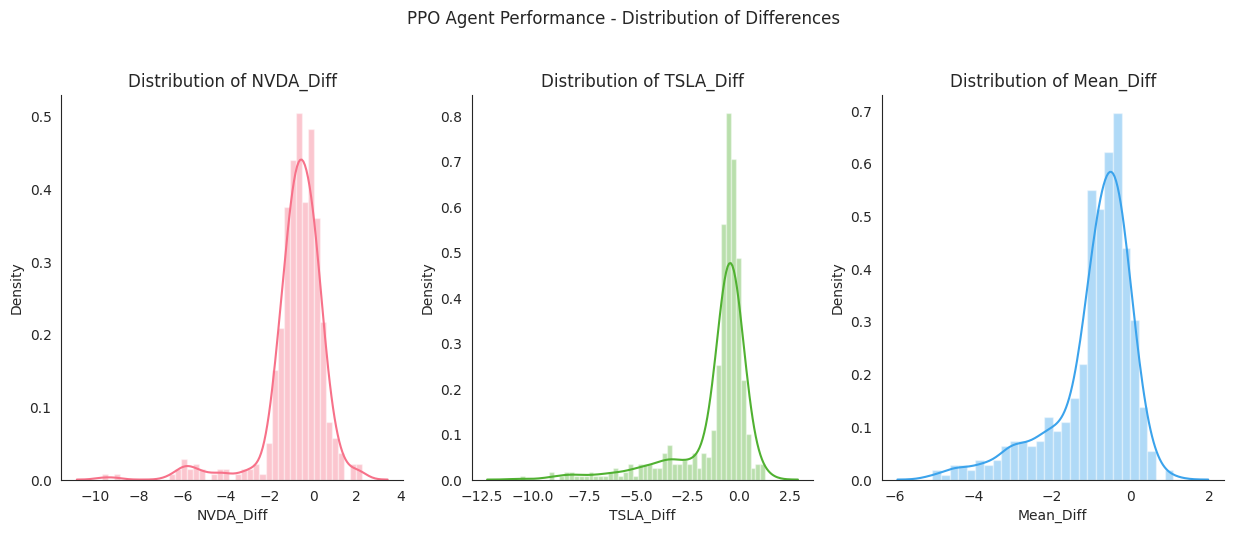

In [ ]:
# Filter columns containing 'Diff' in the column name
diff_columns = [col for col in results.columns if 'Diff' in col]

# Set the seaborn style
with sns.axes_style('white'):
    # Create a figure with subplots based on the number of 'Diff' columns
    fig, axes = plt.subplots(ncols=len(diff_columns), figsize=(5 * len(diff_columns), 5))

    # Define a list of colors for each plot
    colors = sns.color_palette('husl', n_colors=len(diff_columns))

    # Plot the distribution of each 'Difference' column with different colors
    for i, (column, color) in enumerate(zip(diff_columns, colors)):
        sns.distplot(results[column], ax=axes[i], color=color)
        axes[i].set_title(f"Distribution of {column}")
        sns.despine(ax=axes[i])

    # Set the title for the entire figure higher up
    plt.suptitle("PPO Agent Performance - Distribution of Differences", y=1.05)

plt.show()


<ipython-input-34-1133b9f2599e>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results2[column], ax=axes[i], color=color)
<ipython-input-34-1133b9f2599e>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results2[column], ax=axes[i], color=color)
<ipython-input-34-1133b9f2599e>:14: UserWarnin

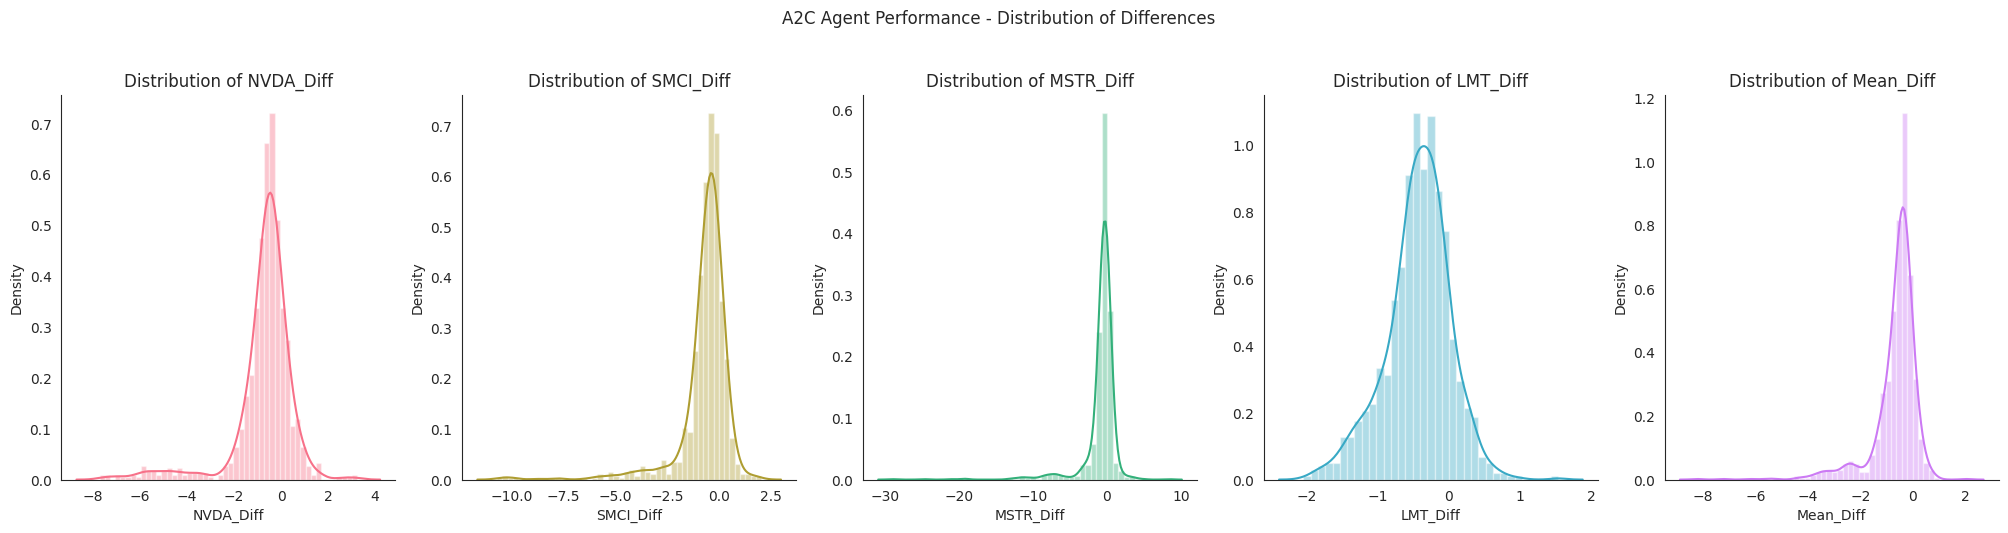

In [ ]:
# Filter columns containing 'Diff' in the column name
diff_columns = [col for col in results2.columns if 'Diff' in col]

# Set the seaborn style
with sns.axes_style('white'):
    # Create a figure with subplots based on the number of 'Diff' columns
    fig, axes = plt.subplots(ncols=len(diff_columns), figsize=(5 * len(diff_columns), 5))

    # Define a list of colors for each plot
    colors = sns.color_palette('husl', n_colors=len(diff_columns))

    # Plot the distribution of each 'Difference' column with different colors
    for i, (column, color) in enumerate(zip(diff_columns, colors)):
        sns.distplot(results2[column], ax=axes[i], color=color)
        axes[i].set_title(f"Distribution of {column}")
        sns.despine(ax=axes[i])

    # Set the title for the entire figure higher up
    plt.suptitle("A2C Agent Performance - Distribution of Differences", y=1.05)

plt.show()


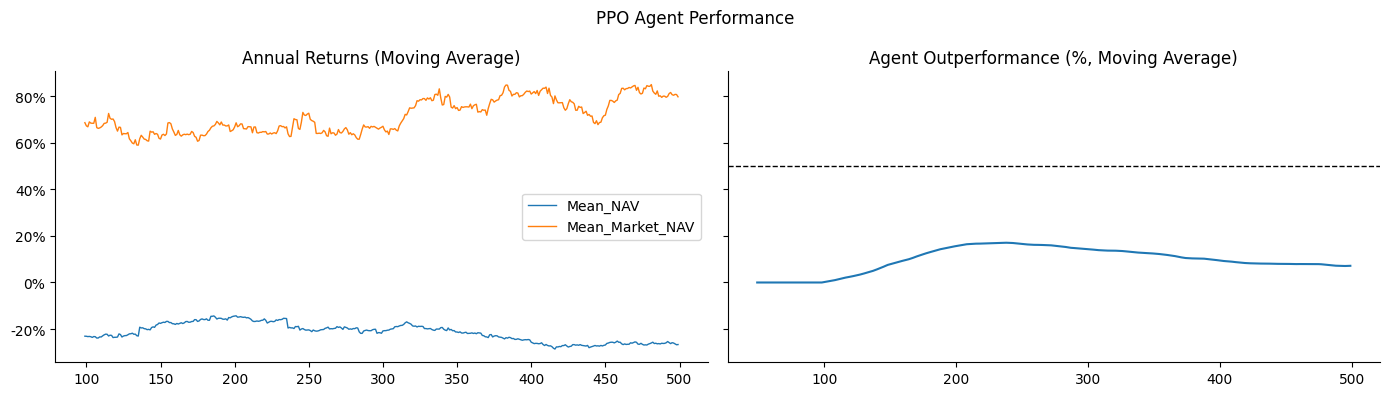

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Mean_NAV', 'Mean_Market_NAV']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%) Mean'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.suptitle('PPO Agent Performance')
fig.tight_layout()

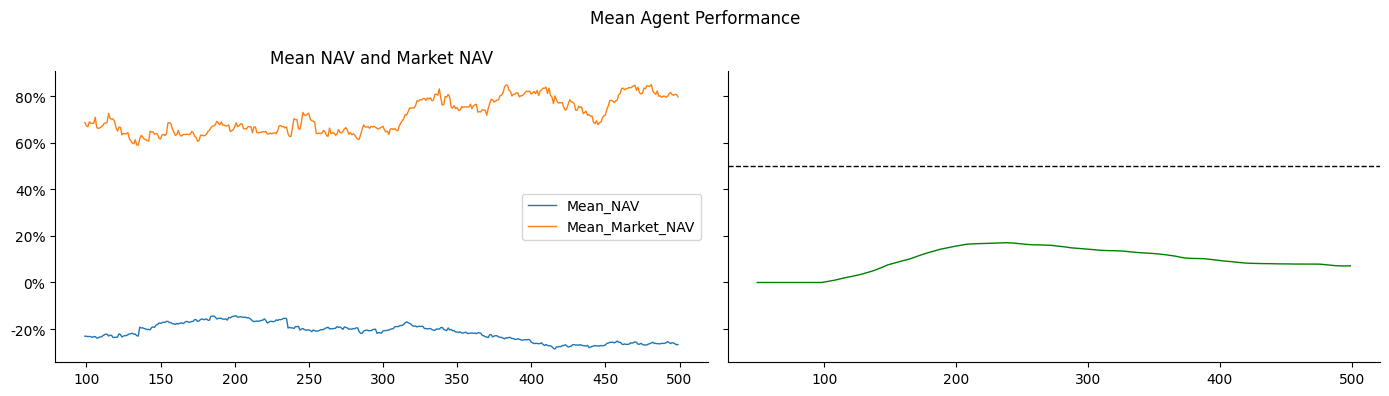

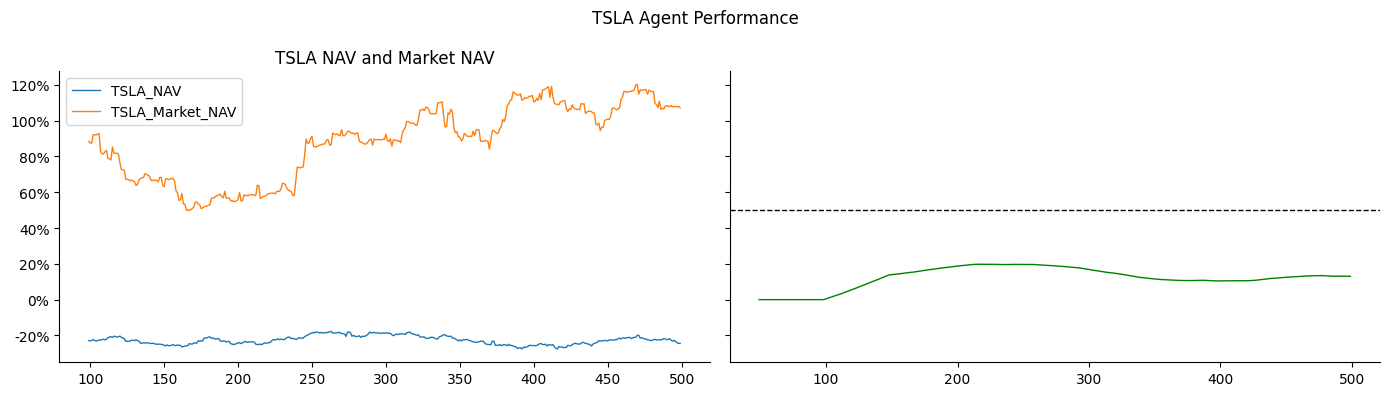

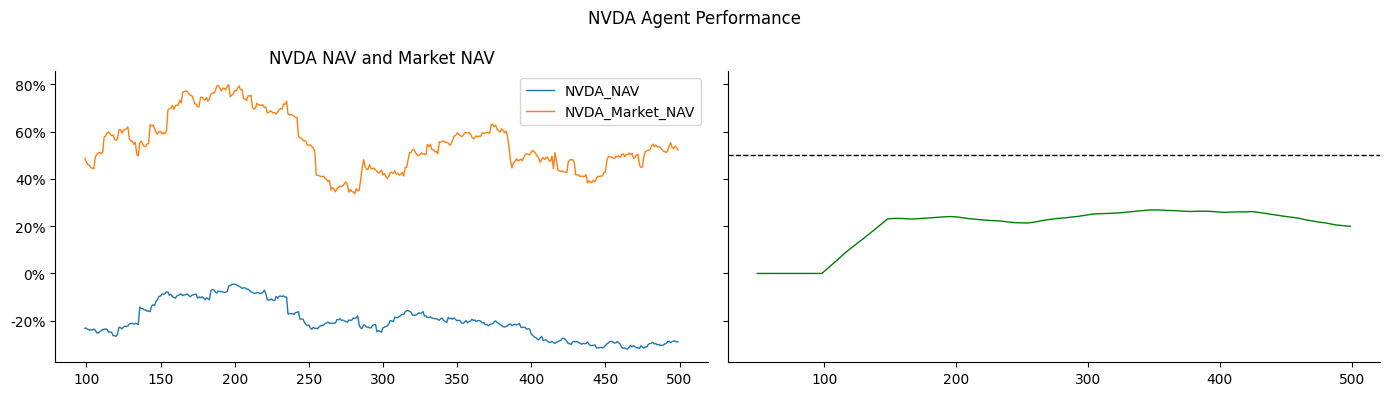

In [ ]:
# Get all unique tickers from the column names
tickers = set(column.split('_')[0] for column in results.columns if 'NAV' in column)

# Create a separate plot for each ticker and mean
for ticker in tickers:
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

    # Filter columns containing NAV and Market_NAV for the current ticker
    filtered_columns = [col for col in results.columns if ticker in col and 'NAV' in col]
    df_nav_market = results[filtered_columns].sub(1).rolling(100).mean()

    # Plot NAV and Market NAV for the current ticker
    df_nav_market.plot(ax=axes[0], lw=1)
    axes[0].set_title(f'{ticker} NAV and Market NAV')

    # Calculate mean for NAV and Market NAV
    strategy_column = f'Strategy Wins (%) {ticker}'
    strategy_data = results[strategy_column].div(100).rolling(50).mean()
    strategy_data.plot(ax=axes[1], lw=1, color='g')

    # Add formatting to y-axis
    for ax in axes:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    axes[1].axhline(.5, ls='--', c='k', lw=1)
    # Remove spines
    sns.despine()
    fig.suptitle(f'{ticker} Agent Performance')
    fig.tight_layout()

# Show all plots
plt.show()


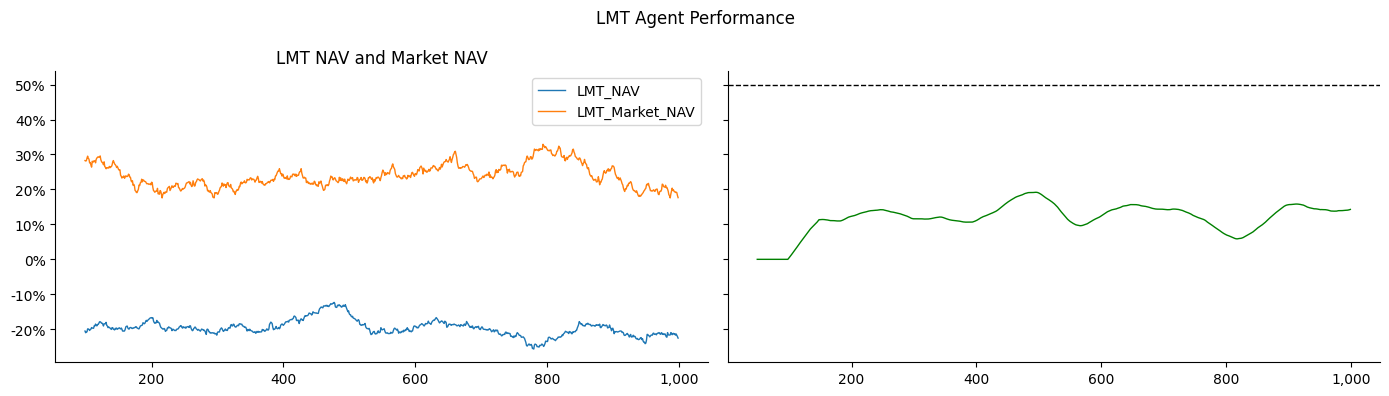

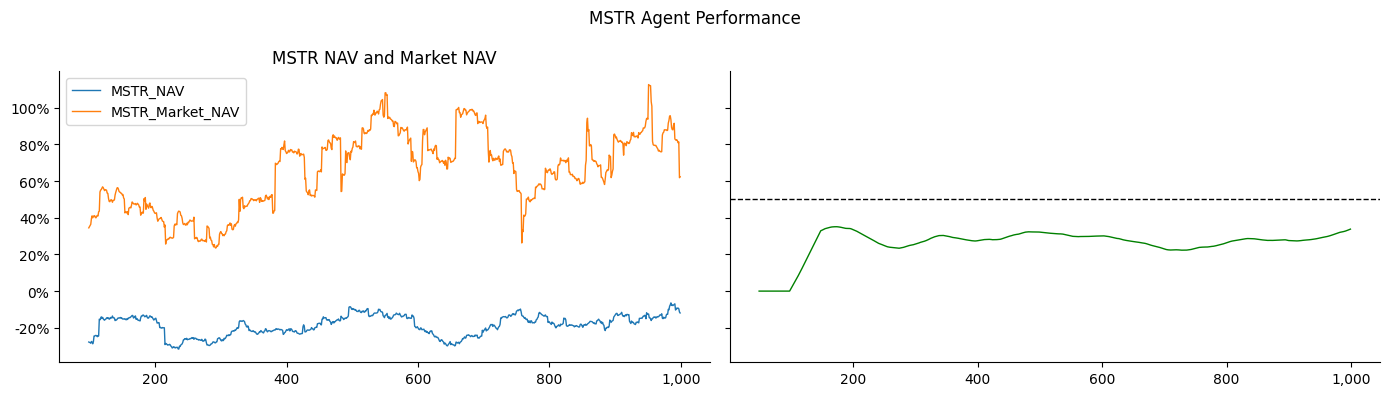

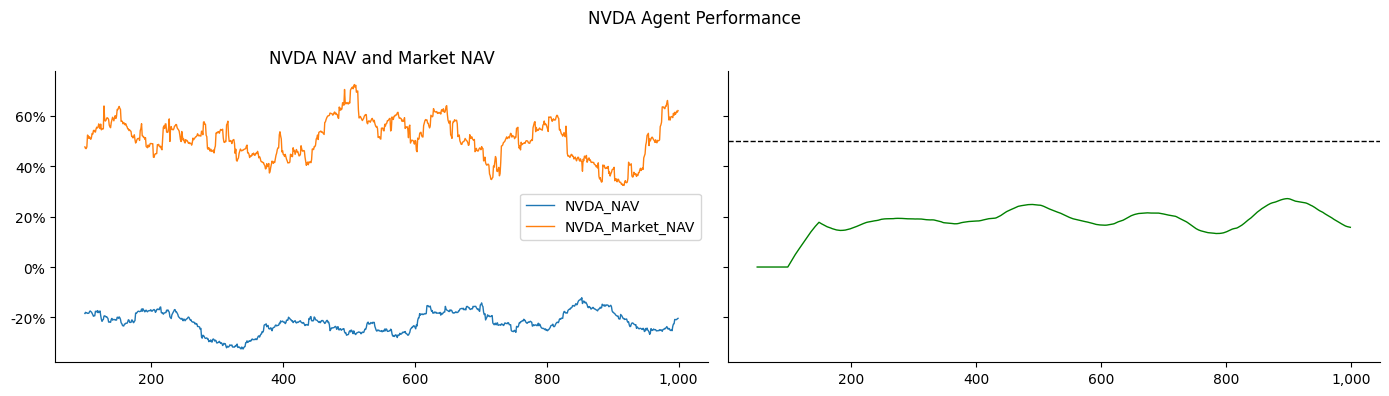

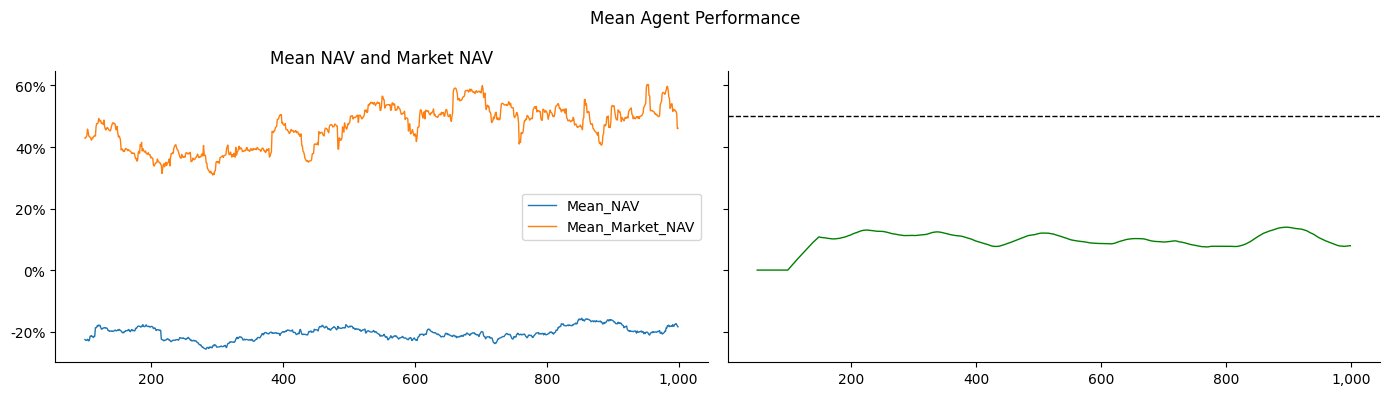

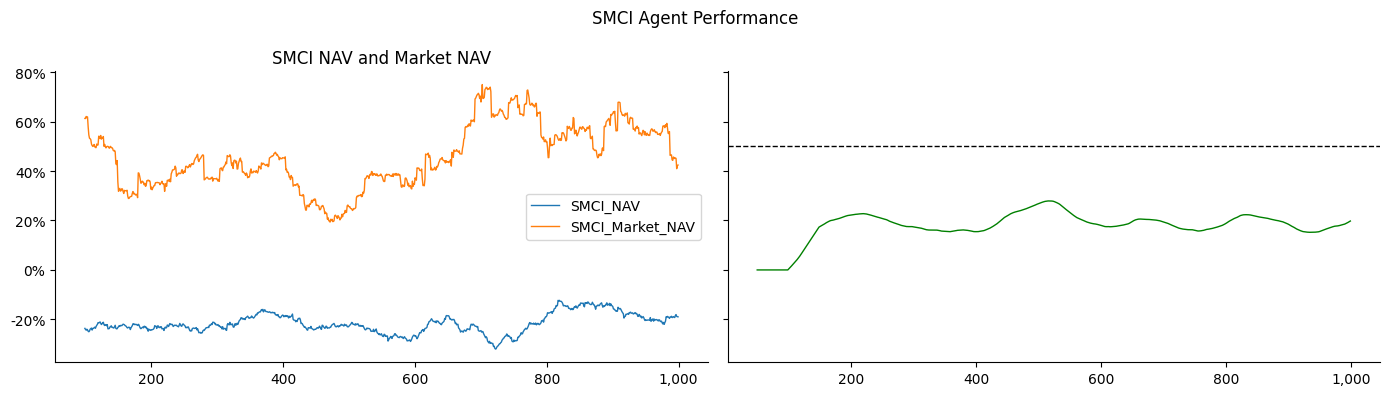

In [ ]:
# Get all unique tickers from the column names
tickers = set(column.split('_')[0] for column in results2.columns if 'NAV' in column)

# Create a separate plot for each ticker and mean
for ticker in tickers:
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

    # Filter columns containing NAV and Market_NAV for the current ticker
    filtered_columns = [col for col in results2.columns if ticker in col and 'NAV' in col]
    df_nav_market = results2[filtered_columns].sub(1).rolling(100).mean()

    # Plot NAV and Market NAV for the current ticker
    df_nav_market.plot(ax=axes[0], lw=1)
    axes[0].set_title(f'{ticker} NAV and Market NAV')

    # Calculate mean for NAV and Market NAV
    strategy_column = f'Strategy Wins (%) {ticker}'
    strategy_data = results2[strategy_column].div(100).rolling(50).mean()
    strategy_data.plot(ax=axes[1], lw=1, color='g')

    # Add formatting to y-axis
    for ax in axes:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    axes[1].axhline(.5, ls='--', c='k', lw=1)
    # Remove spines
    sns.despine()
    fig.suptitle(f'{ticker} Agent Performance')
    fig.tight_layout()

# Show all plots
plt.show()


NameError: name 'results2' is not defined

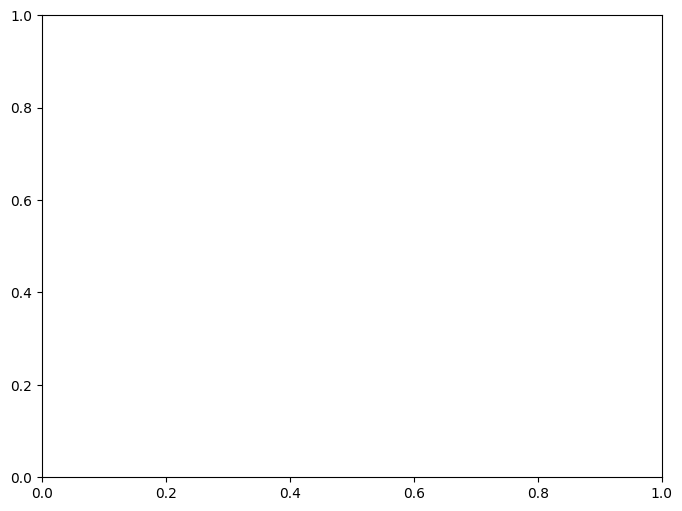

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Define the ticker
ticker = 'Mean'

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Filter columns containing NAV and Market NAV for the ticker 'Mean' in results
filtered_columns_nav_results = [col for col in results.columns if ticker in col and 'NAV' in col]
df_nav_market_results = results[filtered_columns_nav_results].sub(1).rolling(100).mean()

# Filter columns containing NAV and Market NAV for the ticker 'Mean' in results2
filtered_columns_nav_results2 = [col for col in results2.columns if ticker in col and 'NAV' in col]
df_nav_market_results2 = results2[filtered_columns_nav_results2].sub(1).rolling(100).mean()

# Plot NAV and Market NAV for the ticker 'Mean' from results
df_nav_market_results.plot(ax=ax, lw=1, label='PPO')

# Plot NAV and Market NAV for the ticker 'Mean' from results2
df_nav_market_results2.plot(ax=ax, lw=1, label='A2C')

# Add formatting to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Add horizontal line for reference
ax.axhline(0, ls='--', c='k', lw=1)

# Add legend
ax.legend(['PPO NAV', 'PPO Market NAV', 'A2C NAV', 'A2C Market Nav'])

# Set labels and title
plt.xlabel('Episode')
plt.ylabel('NAV and Market NAV')
plt.title('Agent Performance')

# Remove spines
sns.despine()

# Show the plot
plt.show()


NameError: name 'results2' is not defined

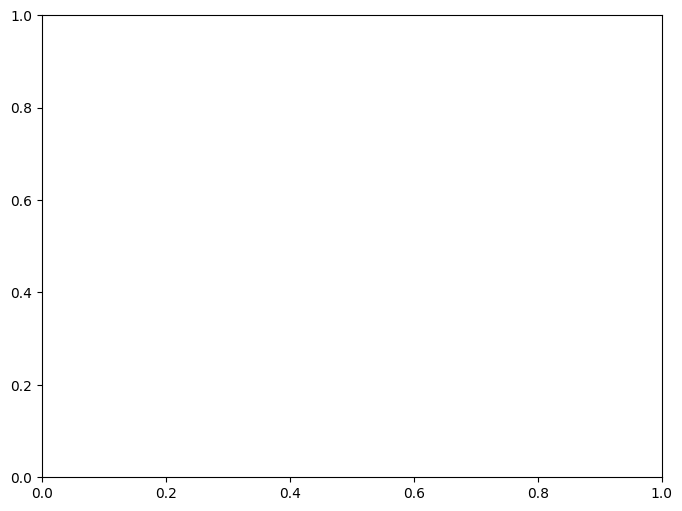

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Define the ticker
ticker = 'Mean'

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Filter columns containing the rolling mean of strategy wins (%) for the ticker 'Mean' from results
filtered_columns_strategy_results = [col for col in results.columns if ticker in col and 'Strategy Wins' in col]
strategy_data_results = results[filtered_columns_strategy_results] / 100
strategy_data_results = strategy_data_results.rolling(50).mean()

# Filter columns containing the rolling mean of strategy wins (%) for the ticker 'Mean' from results2
filtered_columns_strategy_results2 = [col for col in results2.columns if ticker in col and 'Strategy Wins' in col]
strategy_data_results2 = results2[filtered_columns_strategy_results2] / 100
strategy_data_results2 = strategy_data_results2.rolling(50).mean()

# Plot the rolling mean of strategy wins (%) for the ticker 'Mean' from results
strategy_data_results.plot(ax=ax, lw=1, label='PPO')

# Plot the rolling mean of strategy wins (%) for the ticker 'Mean' from results2
strategy_data_results2.plot(ax=ax, lw=1, label='A2C')

# Add horizontal line for reference
ax.axhline(0.5, ls='--', c='k', lw=1)

# Add legend
ax.legend(['PPO', 'A2C'])

# Add formatting to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Set labels and title
plt.xlabel('Episode')
plt.ylabel('Strategy Wins (%) (Moving Average)')
plt.title('Agent Strategy Performance')

# Remove spines
sns.despine()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MEAN']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


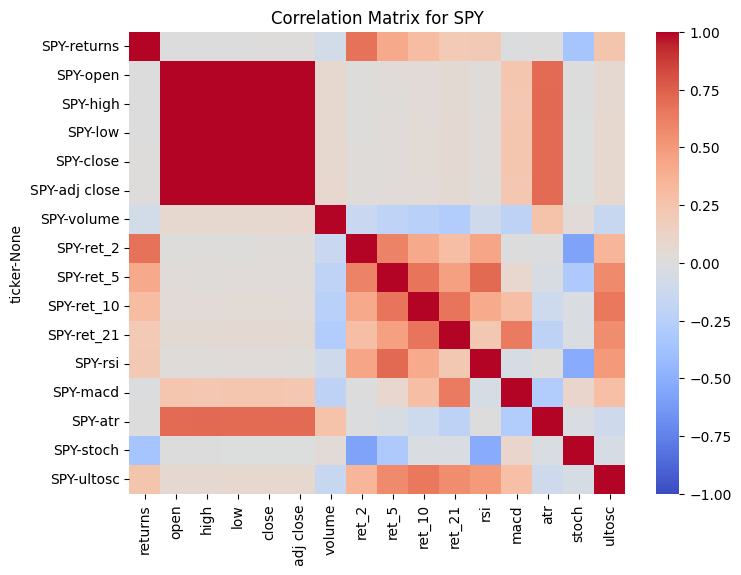

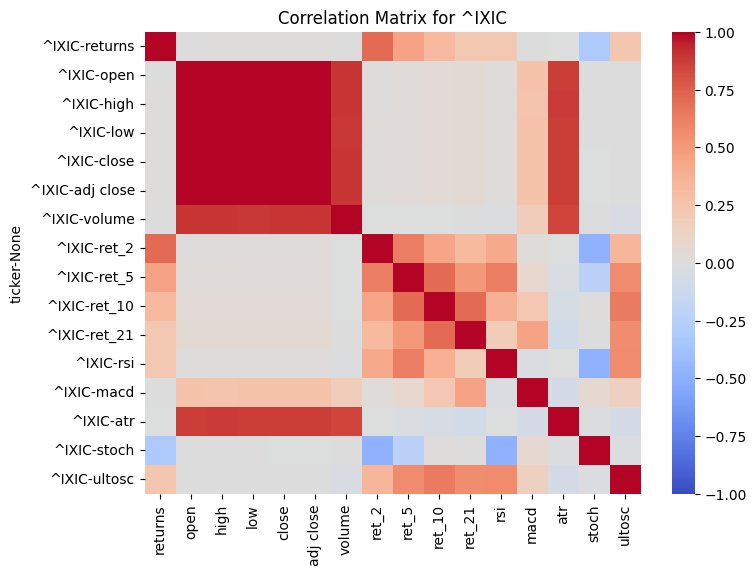

In [ ]:
df = DataSource(tickers).data
correlation_matrices = df.groupby('ticker').corr()

# Plot correlation matrix for each unique ticker
for ticker, corr_matrix in correlation_matrices.groupby(level=0):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()